## Occupancy Estimation    
Occupancy sensors provide real-time data that can be actioned to improve processes across building spaces. The benefits of occupancy sensors include creating more practical spaces that meet people’s needs, based on demand data, ensuring maintenance is efficient, identifying vacant spaces then reducing costs and waste, by controlling lighting and temperature.    
**Dataset and Objective**    
For this purpose, I will use a publicly available dataset on the "Room Occupancy Estimation Data Set" from the UCI Machine Learning Repository. This dataset includes information gathered from multiple non-intrusive environmental sensors like temperature, light, sound, CO2, and PIR (Passive Infrared). The goal is to estimate the precise number of occupants in a room.    
**Methodology**    
Using machine learning classification models, Utilize Python and Scikit-learn for implementation, I will investigate whether ensemble techniques can outperform individual ML models, Conduct 10-folds cross-validation for performance assessment. I will employ statistical analysis to address class imbalance, identify relevant features, test hypotheses about feature importance,... 
By leveraging the capabilities of occupancy sensors and advanced machine learning techniques, we can make informed decisions about space utilization, contributing to a more sustainable and efficient built environment.

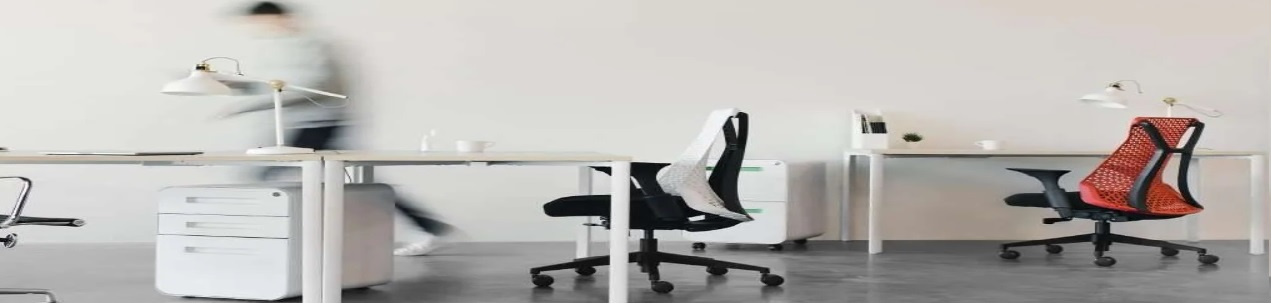

In [ ]:
import ydata_profiling

import pandas as pd
import numpy as np
import statistics as stat
import warnings
import datetime
from datetime import time, date

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import skew, chi2_contingency
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tabulate import tabulate

import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from pandasgui import show

warnings.filterwarnings("ignore")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette('Set2')) 

In [43]:
def anova_(feature):
    labels = df_occupancy['Room_Occupancy_Count'].unique()
    groouped_values = []

    for label in labels:
        groouped_values.append(df_occupancy[df_occupancy['Room_Occupancy_Count'] == label][feature])

    return stats.f_oneway(*groouped_values)

In [44]:
def chi2_(feature):
    ct = pd.crosstab(index = df_occupancy[feature], columns = df_occupancy['Room_Occupancy_Count'])
    ch2_result = chi2_contingency(ct,)
    p , x = "p value : " + str(ch2_result[1]) , str(feature) + " is correlated to Room_Occupancy_Count" if ch2_result[1] < 0.05  else str(feature) + " is not-correlated to Room_Occupancy_Count"
    return p, x

# 
## Exploratory Data Analysis:    
- **EDA** In this part let's summarize dataset's characteristics, using a combination of statistical calculation and data visualization.    

# 
### Data Story:    

**Categorical:**    
- **Ordinal**
    > - **Date** YYYY/MM/DD: the date of the experiment 
    > - **Time**:  HH:MM:SS the time of the experiment 
    > - **Room_Occupancy_Count**: Ground Truth(0 to 3)
    ** Manual establishment of ground truth through registering the exact time and desk number for individuals entering or leaving the room.

**Numeric:** 
- **Continous** 
    >  - **S1_Temp**: Sensor node 1 temperature(celesius)
    >  - **S2_Temp**: Sensor node 2 temperature(celesius) 
    >  - **S3_Temp**: Sensor node 3 temperature(celesius) 
    >  - **S4_Temp**: Sensor node 4 temperature(celesius) 
    >  - **S1_Light**: Sensor node 1 light(LUX) 
    >  - **S2_Light**: Sensor node 2 light(LUX) 
    >  - **S3_Light**: Sensor node 3 light(LUX) 
    >  - **S4_Light**: Sensor node 4 light(LUX) 
    >  - **S1_Sound**: Sensor node 1 sound(voltage) 
    >  - **S2_Sound**: Sensor node 2 sound(voltage) 
    >  - **S3_Sound**: Sensor node 3 sound(voltage) 
    >  - **S4_Sound**: Sensor node 4 sound(voltage) 
    >  - **S5_CO2**: Sensor node 5 CO2 
    >  - **S5_CO2_Slope**: An Improved Correlation with Room_Occupancy(A regression based method is proposed for calculating a new CO2 slope)    
    >  - **S6_PIR**: digital passive infrared (PIR) sensor node 6 in the room(Binay) 
    >  - **S7_PIR**: digital passive infrared (PIR) sensor node 7 in the room(Binay)
    

In [45]:
df_occupancy = pd.read_csv('Occupancy_Estimation.csv')
df_occupancy.head(5)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [46]:
df_occupancy.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [47]:
print("The shape of the data (row, column):", str(df_occupancy.shape))
st = "Data has duplicates" if (any (df_occupancy.duplicated())) else "Data has no duplicates"
print(st)
st = "Data has missing values" if (any (df_occupancy.isna().sum() > 0)) else "Data has no missing values"
print(st)

The shape of the data (row, column): (10129, 19)
Data has no duplicates
Data has no missing values


# 
## Univariate Statistics:
 Means one variable or one type of data. It does not deal with relationships between two or more variables.
Here is to understand the relationship among the data including shape and the spread of the data and the validity to use it for a variety of different predictive algorithms down the road for developing a machine learning pipeline.    
- **There are three types of univariate statistics for each variable:**    
    >    1- **General information:**(data type, count of total values, number of unique values)    
    >    2- **Range and middle:**(min, max, mean, median, mode, quartiles)    
    >    3- **Normality and spread:**(standard deviation, skewness)

In [48]:
df_occupancy.describe().T

,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.940000,25.190000,25.38,25.63,26.380000
S2_Temp,10129.0,25.546059,0.586325,24.750000,25.190000,25.38,25.63,29.000000
S3_Temp,10129.0,25.056621,0.427283,24.440000,24.690000,24.94,25.38,26.190000
S4_Temp,10129.0,25.754125,0.356434,24.940000,25.440000,25.75,26.00,26.560000
S1_Light,10129.0,25.445059,51.011264,0.000000,0.000000,0.00,12.00,165.000000
S2_Light,10129.0,26.016290,67.304170,0.000000,0.000000,0.00,14.00,258.000000
S3_Light,10129.0,34.248494,58.400744,0.000000,0.000000,0.00,50.00,280.000000
S4_Light,10129.0,13.220259,19.602219,0.000000,0.000000,0.00,22.00,74.000000
S1_Sound,10129.0,0.168178,0.316709,0.060000,0.070000,0.08,0.08,3.880000
S2_Sound,10129.0,0.120066,0.266503,0.040000,0.050000,0.05,0.06,3.440000


In [49]:
# # 1- General information:(data type, count of total values, number of unique values)
# print(f'"Date" Type:{df_occupancy.Date.dtype} , COUNT:{df_occupancy.Date.count()} , N Unique:{len(df_occupancy.Date.unique())}')
# print(f'"Time" Type:{df_occupancy.Time.dtype} , COUNT:{df_occupancy.Time.count()} , N Unique:{len(df_occupancy.Time.unique())}')
# print(f'"S1_Light" Type:{df_occupancy.S1_Light.dtype} , COUNT:{df_occupancy.S1_Light.count()} , N Unique:{len(df_occupancy.S1_Light.unique())}')
# print(f'"S2_Light" Type:{df_occupancy.S2_Light.dtype} , COUNT:{df_occupancy.S2_Light.count()} , N Unique:{len(df_occupancy.S2_Light.unique())}')
# print(f'"S3_Light" Type:{df_occupancy.S3_Light.dtype} , COUNT:{df_occupancy.S3_Light.count()} , N Unique:{len(df_occupancy.S3_Light.unique())}')
# print(f'"S4_Light" Type:{df_occupancy.S4_Light.dtype} , COUNT:{df_occupancy.S4_Light.count()} , N Unique:{len(df_occupancy.S4_Light.unique())}')
# print(f'"S5_CO2" Type:{df_occupancy.S5_CO2.dtype} , COUNT:{df_occupancy.S5_CO2.count()} , N Unique:{len(df_occupancy.S5_CO2.unique())}')
# print(f'"S6_PIR" Type:{df_occupancy.S6_PIR.dtype} , COUNT:{df_occupancy.S6_PIR.count()} , N Unique:{len(df_occupancy.S6_PIR.unique())}')
# print(f'"S7_PIR" Type:{df_occupancy.S7_PIR.dtype} , COUNT:{df_occupancy.S7_PIR.count()} , N Unique:{len(df_occupancy.S7_PIR.unique())}')
# print(f'"Room_Occupancy_Count" Type:{df_occupancy.Room_Occupancy_Count.dtype} , COUNT:{df_occupancy.Room_Occupancy_Count.count()} , N Unique:{len(df_occupancy.Room_Occupancy_Count.unique())}')
# print(f'"S1_Temp" Type:{df_occupancy.S1_Temp.dtype} , COUNT:{df_occupancy.S1_Temp.count()} , N Unique:{len(df_occupancy.S1_Temp.unique())}')
# print(f'"S2_Temp" Type:{df_occupancy.S2_Temp.dtype} , COUNT:{df_occupancy.S2_Temp.count()} , N Unique:{len(df_occupancy.S2_Temp.unique())}')
# print(f'"S3_Temp" Type:{df_occupancy.S3_Temp.dtype} , COUNT:{df_occupancy.S3_Temp.count()} , N Unique:{len(df_occupancy.S3_Temp.unique())}')
# print(f'"S4_Temp" Type:{df_occupancy.S4_Temp.dtype} , COUNT:{df_occupancy.S4_Temp.count()} , N Unique:{len(df_occupancy.S4_Temp.unique())}')
# print(f'"S1_Sound" Type:{df_occupancy.S1_Sound.dtype} , COUNT:{df_occupancy.S1_Sound.count()} , N Unique:{len(df_occupancy.S1_Sound.unique())}')
# print(f'"S2_Sound" Type:{df_occupancy.S2_Sound.dtype} , COUNT:{df_occupancy.S2_Sound.count()} , N Unique:{len(df_occupancy.S2_Sound.unique())}')
# print(f'"S3_Sound" Type:{df_occupancy.S3_Sound.dtype} , COUNT:{df_occupancy.S3_Sound.count()} , N Unique:{len(df_occupancy.S3_Sound.unique())}')
# print(f'"S4_Sound" Type:{df_occupancy.S4_Sound.dtype} , COUNT:{df_occupancy.S4_Sound.count()} , N Unique:{len(df_occupancy.S4_Sound.unique())}')
# print(f'"S5_CO2_Slope" Type:{df_occupancy.S5_CO2_Slope.dtype} , COUNT:{df_occupancy.S5_CO2_Slope.count()} , N Unique:{len(df_occupancy.S5_CO2_Slope.unique())}')

# # 2- Range and middle:(min, max, mean, median, mode, quartiles)
# #    Printing Boundries and Middle of numeric variables
# print(f'"S1_Light" Min:{df_occupancy.S1_Light.min()} , Quantile25:{df_occupancy.S1_Light.quantile(.25)} , Quantile50:{df_occupancy.S1_Light.quantile(.50)} , Quantile75:{df_occupancy.S1_Light.quantile(.75)} , Max:{df_occupancy.S1_Light.max()} , Mean:{df_occupancy.S1_Light.mean()} , Median:{df_occupancy.S1_Light.median()}, Mode:{df_occupancy.S1_Light.mode()}')
# print(f'"S2_Light" Min:{df_occupancy.S2_Light.min()} , Quantile25:{df_occupancy.S2_Light.quantile(.25)} , Quantile50:{df_occupancy.S2_Light.quantile(.50)} , Quantile75:{df_occupancy.S2_Light.quantile(.75)} , Max:{df_occupancy.S2_Light.max()} , Mean:{df_occupancy.S2_Light.mean()} , Median:{df_occupancy.S2_Light.median()}, Mode:{df_occupancy.S2_Light.mode()}')
# print(f'"S3_Light" Min:{df_occupancy.S3_Light.min()} , Quantile25:{df_occupancy.S3_Light.quantile(.25)} , Quantile50:{df_occupancy.S3_Light.quantile(.50)} , Quantile75:{df_occupancy.S3_Light.quantile(.75)} , Max:{df_occupancy.S3_Light.max()} , Mean:{df_occupancy.S3_Light.mean()} , Median:{df_occupancy.S3_Light.median()}, Mode:{df_occupancy.S3_Light.mode()}')
# print(f'"S4_Light" Min:{df_occupancy.S4_Light.min()} , Quantile25:{df_occupancy.S4_Light.quantile(.25)} , Quantile50:{df_occupancy.S4_Light.quantile(.50)} , Quantile75:{df_occupancy.S4_Light.quantile(.75)} , Max:{df_occupancy.S4_Light.max()} , Mean:{df_occupancy.S4_Light.mean()} , Median:{df_occupancy.S4_Light.median()}, Mode:{df_occupancy.S4_Light.mode()}')
# print(f'"S5_CO2" Min:{df_occupancy.S5_CO2.min()} , Quantile25:{df_occupancy.S5_CO2.quantile(.25)} , Quantile50:{df_occupancy.S5_CO2.quantile(.50)} , Quantile75:{df_occupancy.S5_CO2.quantile(.75)} , Max:{df_occupancy.S5_CO2.max()} , Mean:{df_occupancy.S5_CO2.mean()} , Median:{df_occupancy.S5_CO2.median()}, Mode:{df_occupancy.S5_CO2.mode()}')
# print(f'"S6_PIR" Min:{df_occupancy.S6_PIR.min()} , Quantile25:{df_occupancy.S6_PIR.quantile(.25)} , Quantile50:{df_occupancy.S6_PIR.quantile(.50)} , Quantile75:{df_occupancy.S6_PIR.quantile(.75)} , Max:{df_occupancy.S6_PIR.max()} , Mean:{df_occupancy.S6_PIR.mean()} , Median:{df_occupancy.S6_PIR.median()}, Mode:{df_occupancy.S6_PIR.mode()}')
# print(f'"S7_PIR" Min:{df_occupancy.S7_PIR.min()} , Quantile25:{df_occupancy.S7_PIR.quantile(.25)} , Quantile50:{df_occupancy.S7_PIR.quantile(.50)} , Quantile75:{df_occupancy.S7_PIR.quantile(.75)} , Max:{df_occupancy.S7_PIR.max()} , Mean:{df_occupancy.S7_PIR.mean()} , Median:{df_occupancy.S7_PIR.median()}, Mode:{df_occupancy.S7_PIR.mode()}')
# print(f'"Room_Occupancy_Count" Min:{df_occupancy.Room_Occupancy_Count.min()} , Quantile25:{df_occupancy.Room_Occupancy_Count.quantile(.25)} , Quantile50:{df_occupancy.Room_Occupancy_Count.quantile(.50)} , Quantile75:{df_occupancy.Room_Occupancy_Count.quantile(.75)} , Max:{df_occupancy.Room_Occupancy_Count.max()} , Mean:{df_occupancy.Room_Occupancy_Count.mean()} , Median:{df_occupancy.Room_Occupancy_Count.median()}, Mode:{df_occupancy.Room_Occupancy_Count.mode()}')
# print(f'"S1_Temp" Min:{df_occupancy.S1_Temp.min()} , Quantile25:{df_occupancy.S1_Temp.quantile(.25)} , Quantile50:{df_occupancy.S1_Temp.quantile(.50)} , Quantile75:{df_occupancy.S1_Temp.quantile(.75)} , Max:{df_occupancy.S1_Temp.max()} , Mean:{df_occupancy.S1_Temp.mean()} , Median:{df_occupancy.S1_Temp.median()}, Mode:{df_occupancy.S1_Temp.mode()}')
# print(f'"S2_Temp" Min:{df_occupancy.S2_Temp.min()} , Quantile25:{df_occupancy.S2_Temp.quantile(.25)} , Quantile50:{df_occupancy.S2_Temp.quantile(.50)} , Quantile75:{df_occupancy.S2_Temp.quantile(.75)} , Max:{df_occupancy.S2_Temp.max()} , Mean:{df_occupancy.S2_Temp.mean()} , Median:{df_occupancy.S2_Temp.median()}, Mode:{df_occupancy.S2_Temp.mode()}')
# print(f'"S3_Temp" Min:{df_occupancy.S3_Temp.min()} , Quantile25:{df_occupancy.S3_Temp.quantile(.25)} , Quantile50:{df_occupancy.S3_Temp.quantile(.50)} , Quantile75:{df_occupancy.S3_Temp.quantile(.75)} , Max:{df_occupancy.S3_Temp.max()} , Mean:{df_occupancy.S3_Temp.mean()} , Median:{df_occupancy.S3_Temp.median()}, Mode:{df_occupancy.S3_Temp.mode()}')
# print(f'"S4_Temp" Min:{df_occupancy.S4_Temp.min()} , Quantile25:{df_occupancy.S4_Temp.quantile(.25)} , Quantile50:{df_occupancy.S4_Temp.quantile(.50)} , Quantile75:{df_occupancy.S4_Temp.quantile(.75)} , Max:{df_occupancy.S4_Temp.max()} , Mean:{df_occupancy.S4_Temp.mean()} , Median:{df_occupancy.S4_Temp.median()}, Mode:{df_occupancy.S4_Temp.mode()}')
# print(f'"S1_Sound" Min:{df_occupancy.S1_Sound.min()} , Quantile25:{df_occupancy.S1_Sound.quantile(.25)} , Quantile50:{df_occupancy.S1_Sound.quantile(.50)} , Quantile75:{df_occupancy.S1_Sound.quantile(.75)} , Max:{df_occupancy.S1_Sound.max()} , Mean:{df_occupancy.S1_Sound.mean()} , Median:{df_occupancy.S1_Sound.median()}, Mode:{df_occupancy.S1_Sound.mode()}')
# print(f'"S2_Sound" Min:{df_occupancy.S2_Sound.min()} , Quantile25:{df_occupancy.S2_Sound.quantile(.25)} , Quantile50:{df_occupancy.S2_Sound.quantile(.50)} , Quantile75:{df_occupancy.S2_Sound.quantile(.75)} , Max:{df_occupancy.S2_Sound.max()} , Mean:{df_occupancy.S2_Sound.mean()} , Median:{df_occupancy.S2_Sound.median()}, Mode:{df_occupancy.S2_Sound.mode()}')
# print(f'"S3_Sound" Min:{df_occupancy.S3_Sound.min()} , Quantile25:{df_occupancy.S3_Sound.quantile(.25)} , Quantile50:{df_occupancy.S3_Sound.quantile(.50)} , Quantile75:{df_occupancy.S3_Sound.quantile(.75)} , Max:{df_occupancy.S3_Sound.max()} , Mean:{df_occupancy.S3_Sound.mean()} , Median:{df_occupancy.S3_Sound.median()}, Mode:{df_occupancy.S3_Sound.mode()}')
# print(f'"S4_Sound" Min:{df_occupancy.S4_Sound.min()} , Quantile25:{df_occupancy.S4_Sound.quantile(.25)} , Quantile50:{df_occupancy.S4_Sound.quantile(.50)} , Quantile75:{df_occupancy.S4_Sound.quantile(.75)} , Max:{df_occupancy.S4_Sound.max()} , Mean:{df_occupancy.S4_Sound.mean()} , Median:{df_occupancy.S4_Sound.median()}, Mode:{df_occupancy.S4_Sound.mode()}')
# print(f'"S5_CO2_Slope" Min:{df_occupancy.S5_CO2_Slope.min()} , Quantile25:{df_occupancy.S5_CO2_Slope.quantile(.25)} , Quantile50:{df_occupancy.S5_CO2_Slope.quantile(.50)} , Quantile75:{df_occupancy.S5_CO2_Slope.quantile(.75)} , Max:{df_occupancy.S5_CO2_Slope.max()} , Mean:{df_occupancy.S5_CO2_Slope.mean()} , Median:{df_occupancy.S5_CO2_Slope.median()}, Mode:{df_occupancy.S5_CO2_Slope.mode()}')

# # 3- Spread and (Ab)Normality:(standard deviation, skewness)
# print(f'"S1_Light" StdDev:{df_occupancy.S1_Light.std()} , Skew:{df_occupancy.S1_Light.skew()} ')
# print(f'"S2_Light" StdDev:{df_occupancy.S2_Light.std()} , Skew:{df_occupancy.S2_Light.skew()}')
# print(f'"S3_Light" StdDev:{df_occupancy.S3_Light.std()} , Skew:{df_occupancy.S3_Light.skew()}')
# print(f'"S4_Light" StdDev:{df_occupancy.S4_Light.std()} , Skew:{df_occupancy.S4_Light.skew()}')
# print(f'"S5_CO2" StdDev:{df_occupancy.S5_CO2.std()} , Skew:{df_occupancy.S5_CO2.skew()}')
# print(f'"S6_PIR" StdDev:{df_occupancy.S6_PIR.std()} , Skew:{df_occupancy.S6_PIR.skew()}')
# print(f'"S7_PIR" StdDev:{df_occupancy.S7_PIR.std()} , Skew:{df_occupancy.S7_PIR.skew()}')
# print(f'"Room_Occupancy_Count" StdDev:{df_occupancy.Room_Occupancy_Count.std()} ,  Skew:{df_occupancy.Room_Occupancy_Count.skew()}')
# print(f'"S1_Temp" StdDev:{df_occupancy.S1_Temp.std()} , Skew:{df_occupancy.S1_Temp.skew()}')
# print(f'"S2_Temp" StdDev:{df_occupancy.S2_Temp.std()} , Skew:{df_occupancy.S2_Temp.skew()}')
# print(f'"S3_Temp" StdDev:{df_occupancy.S3_Temp.std()} , Skew:{df_occupancy.S3_Temp.skew()}')
# print(f'"S4_Temp" StdDev:{df_occupancy.S4_Temp.std()} , Skew:{df_occupancy.S4_Temp.skew()}')
# print(f'"S1_Sound" StdDev:{df_occupancy.S1_Sound.std()} , Skew:{df_occupancy.S1_Sound.skew()}')
# print(f'"S2_Sound" StdDev:{df_occupancy.S2_Sound.std()} , Skew:{df_occupancy.S2_Sound.skew()}')
# print(f'"S3_Sound" StdDev:{df_occupancy.S3_Sound.std()} , Skew:{df_occupancy.S3_Sound.skew()}')
# print(f'"S4_Sound" StdDev:{df_occupancy.S4_Sound.std()} , Skew:{df_occupancy.S4_Sound.skew()}')
# print(f'"S5_CO2_Slope" StdDev:{df_occupancy.S5_CO2_Slope.std()} , Skew:{df_occupancy.S5_CO2_Slope.skew()}')

<img src="univariate%20statistics.jpg" align="left"/>

# 
###  Quick insights:

-  There are **10129** instances in the dataset.
- **Dependent Variable:** Room_Occupancy_Count is to be predicted and explained with other features in the dataset, it represents a valuable of interest
- **Independent Variable:** All of other features, the one that can predict and explain Room_Occupancy_Count
-  The are **no missing values** (every feature has 10129 observations).
-  **Imbalanced** class Room_Occupancy_Count with many **zero values**(0, 1, 2, 3 values).
-  PIR sensors (S6_PIR, S7_PIR) are **binary** and seem to have mainly **zero values**.
-  Light sensors (S1_Light, S2_Light, S3_Light, S4_Light) have a majority of **zero values**.
-  Temperature sensors show relatively **small variations**.
-  Sound sensors capture **small variations**.
-  Sound levels (S1_Sound, S2_Sound, S3_Sound, S4_Sound) exhibit **high skewness**.

# 
###  Considerations- Next Steps:
-  **Filtering** data based on the **time range** of the day  is advisable when dealing with the imbalanced class Room_Occupancy_Count with many zero values.
-  **Visualizing distributions** for variables with **skewed** / **wide-ranging values** / **small variations** / **Outliers**


# 
## Visualizing Distributions Of Original data

In [50]:
show(df_occupancy)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


# 
### Plot the frequency distribution of Room_Occupancy_Count

In [51]:
zero_occ_count = df_occupancy[df_occupancy['Room_Occupancy_Count'] == 0]['Room_Occupancy_Count'].count()
one_occ_count = df_occupancy[df_occupancy['Room_Occupancy_Count'] == 1]['Room_Occupancy_Count'].count()
two_occ_count = df_occupancy[df_occupancy['Room_Occupancy_Count'] == 2]['Room_Occupancy_Count'].count()
three_occ_count = df_occupancy[df_occupancy['Room_Occupancy_Count'] == 3]['Room_Occupancy_Count'].count()
print(f' zero occupant: {zero_occ_count} , one occupant: {one_occ_count} , two occupants: {two_occ_count} , three occupants: {three_occ_count}')

 zero occupant: 8228 , one occupant: 459 , two occupants: 748 , three occupants: 694


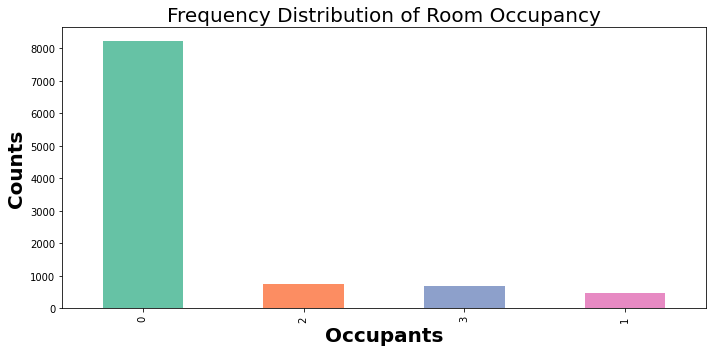

In [52]:
fig, ax = plt.subplots()

df_occupancy['Room_Occupancy_Count'].value_counts().plot(ax=ax, kind='bar', color=sns.color_palette('Set2'));
ax.set_title('Frequency Distribution of Room Occupancy', fontsize=20)
ax.set_xlabel('Occupants' , fontweight = 'bold', fontsize=20)
ax.set_ylabel('Counts' , fontweight = 'bold', fontsize=20)

plt.tight_layout()
plt.show()

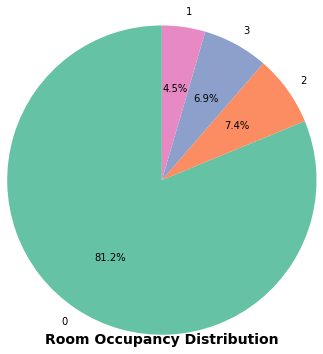

In [53]:
room_occupancy_counts = df_occupancy['Room_Occupancy_Count'].value_counts()

fig, ax = plt.subplots()
ax.pie(room_occupancy_counts, labels=room_occupancy_counts.index, autopct='%1.1f%%', startangle=90, radius = 1.3)

ax.set_xlabel('Room Occupancy Distribution', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

# 
### Visualizing data from selective sensors and the CO2 slope for a period of 12 hours on 23/12/2017.

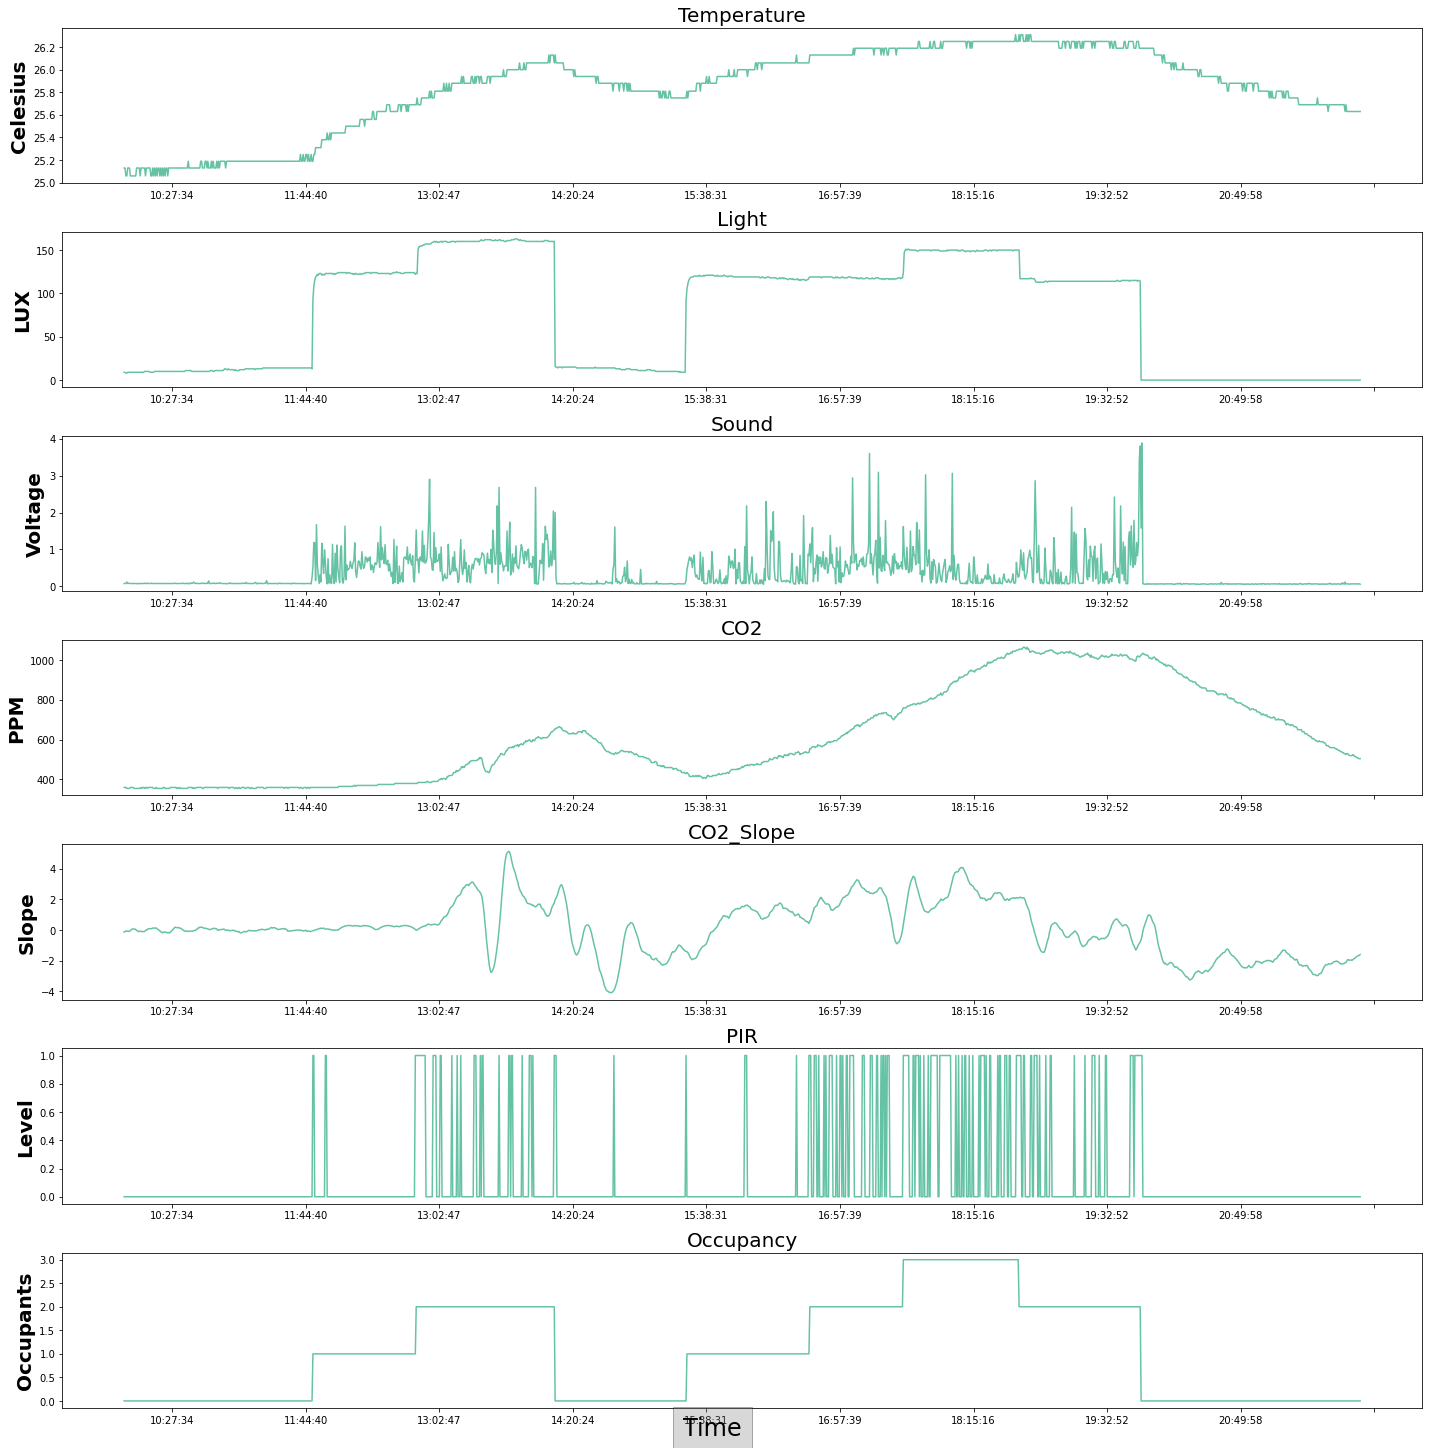

In [54]:
features_dict = {'S1_Temp':'Celesius', 'S1_Light':'LUX', 'S1_Sound':'Voltage', 'S5_CO2':'PPM', 
                 'S5_CO2_Slope':'Slope', 'S7_PIR':'Level', 'Room_Occupancy_Count':'Occupants'}
title = ['Temperature', 'Light', 'Sound', 'CO2', 'CO2_Slope', 'PIR', 'Occupancy']


df_23_12_2017_12_hr = df_occupancy.loc[(pd.to_datetime(df_occupancy['Time'],format= '%H:%M:%S').dt.time >= time(10,0,0)) &
                                       (pd.to_datetime(df_occupancy['Time'],format= '%H:%M:%S').dt.time <= time(22,0,0)) &
                                       (pd.to_datetime(df_occupancy['Date'],format= '%Y/%m/%d').dt.date == date(2017,12,23))]

fig, axs = plt.subplots(7, figsize=(20, 20))

for i, (feature, scale) in enumerate(features_dict.items()):
    sns.lineplot(ax=axs[i], x='Time', y=feature, data=df_23_12_2017_12_hr)

    axs[i].set_title(title[i], fontsize=20)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(scale , fontweight = 'bold', fontsize=20)
        
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval= 3600, byhour=range(24)))
#     axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

figtext_args = (0.5, 0, "Time") 
figtext_kwargs = dict(horizontalalignment ="center",  
                      fontsize = 24, wrap = True,
                      bbox ={'facecolor':'grey',  
                             'alpha':0.3, 'pad':10}) 

plt.figtext(*figtext_args, **figtext_kwargs) 

plt.tight_layout()
plt.show()

# 
# Visualizing Outliers
-  Features with outliers can be identified by considering those with a high standard deviation. Specifically, features with a large standard deviation relative to the mean and a notable difference between the mean and the maximum value are indicative of potential outliers.   
-  Attributes such as **"S1_Light", "S2_Light", "S3_Light", "S4_Light", "S5_CO2", "S6_PIR", and "S7_PIR"** exhibit characteristics that suggest the presence of outliers.   
-  For binary variables "S6_PIR" and "S7_PIR, the focus is on **patterns and correlations** rather than outliers, since there are only two distinct values(0 or 1), the concept of outliers doesn't apply. 

Visualizing these attributes would help in further assessing and deciding how to treat potential outliers.

# 
### Lights Outliers 

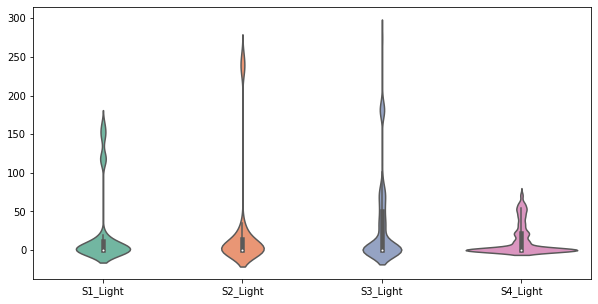

In [55]:
sns.violinplot(data=df_occupancy[['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']])
plt.show()

**Insight:**
There are lots of outliers for all light sensors, we can see that the more density is around (0 or no light). Indoor light levels range between 100 and 300(LUX), those are above the 75th percentile and important. Excluding them  will lead to the loss of valuable information.

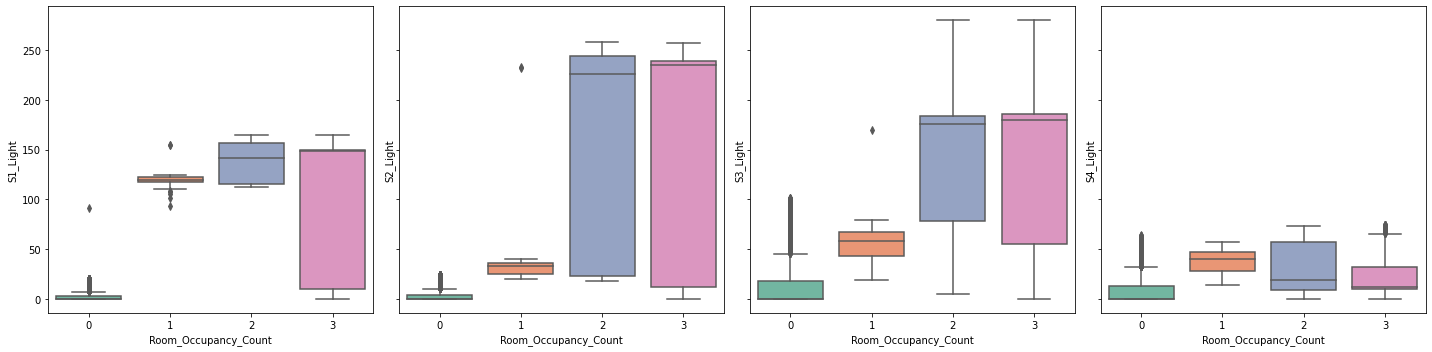

In [56]:
features_to_visualize = ["S1_Light", "S2_Light", "S3_Light", "S4_Light"]

fig, axs = plt.subplots(1, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 5))
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(ax=axs[i], x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy[feature], 
                palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()


From the boxplots, we can see that for unoccupied rooms, light levels are consistently below 100(LUX), with noticeable outlier points, indicating lower variability. Occupied rooms, however, exhibit a wider and more varied range of light levels with no significant outliers.

# 
### CO2 Outliers 

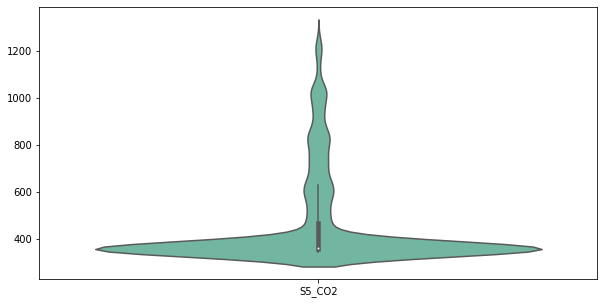

In [57]:
sns.violinplot(data=df_occupancy[['S5_CO2']])
plt.show()

**Insight:**
There are many outliers for CO2, we can see that the density is around (400ppm). Typical indoors CO2 level with good ventilation range between 400 and 1100(ppm),  value level greater than 1,200ppm shows a poor air quality and requires ventilation to the room. As the extreme values of the CO2 level are valuable, excluding them  will lead to the loss of valuable information.

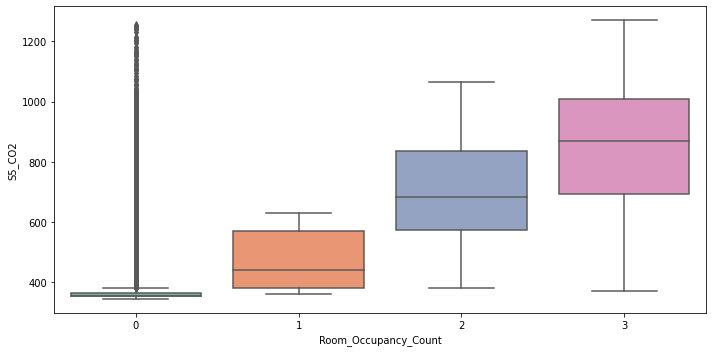

In [58]:
fig, axs = plt.subplots(1, sharex='col', sharey='row', figsize=(10, 5))
       
sns.boxplot(ax=axs, x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy["S5_CO2"], 
            palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

From the boxplots, we can see that for unoccupied rooms, CO2 levels are consistently below 400(ppm), indicating lower variability, with noticeable outlier points. Occupied rooms, however, exhibit a wider and more varied normal range of CO2 levels with no significant outliers."

# 
### ----------------------------------------------------------------------------------------------------------------------------------------------------------

# 
# Visualization

# 
### Visualization ( Temperature Sensors )

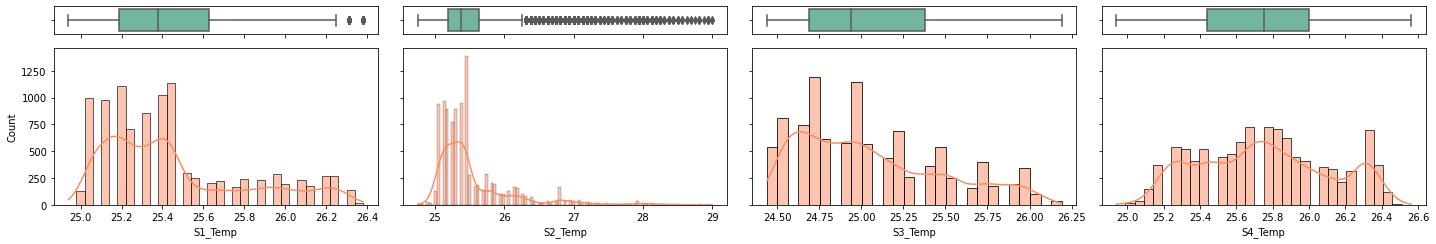

In [59]:
features_to_visualize = ["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp"]

fig, axs = plt.subplots(2, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 3.5),
                       gridspec_kw={"height_ratios": [.15,.85]})
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(df_occupancy[feature], orient="h", ax=axs[0, i], color='#66c2a5')
    sns.histplot(data=df_occupancy, x=feature, ax=axs[1, i], color='#fc8d62', kde=True)

    axs[0, i].set(xlabel='')
    axs[1, i].set(xlabel=feature)

plt.tight_layout()
plt.show()

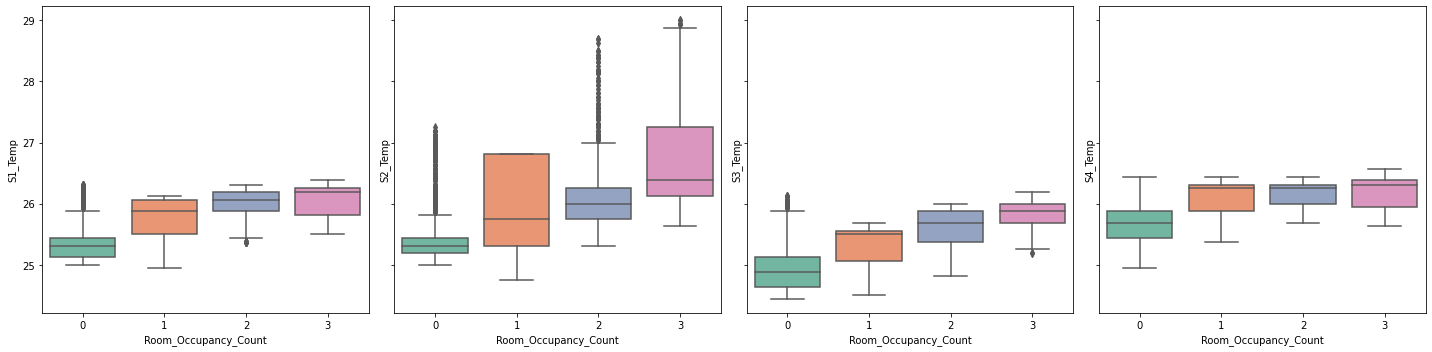

In [60]:
fig, axs = plt.subplots(1, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 5))
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(ax=axs[i], x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy[feature], 
                palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

# 
### Visualization ( Lights Sensors ) 

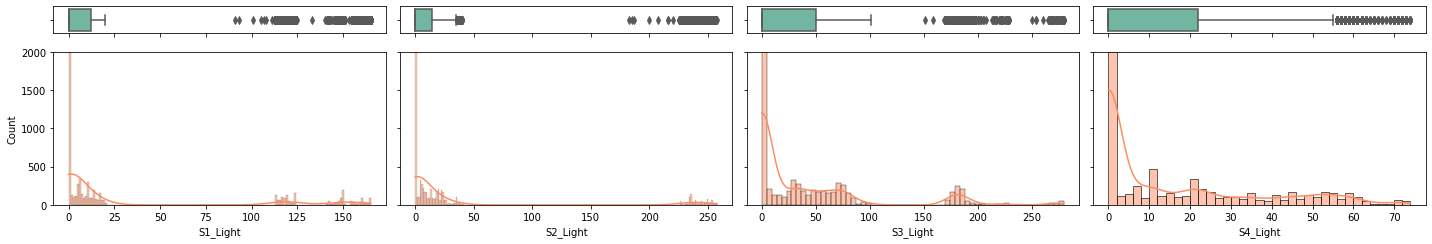

In [61]:
features_to_visualize = ["S1_Light", "S2_Light", "S3_Light", "S4_Light"]

fig, axs = plt.subplots(2, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 3.5),
                       gridspec_kw={"height_ratios": [.15,.85]})
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(df_occupancy[feature], orient="h", ax=axs[0, i], color='#66c2a5')
    sns.histplot(data=df_occupancy, x=feature, ax=axs[1, i], color='#fc8d62', kde=True)

    axs[0, i].set(xlabel='')
    axs[1, i].set(xlabel=feature)

plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

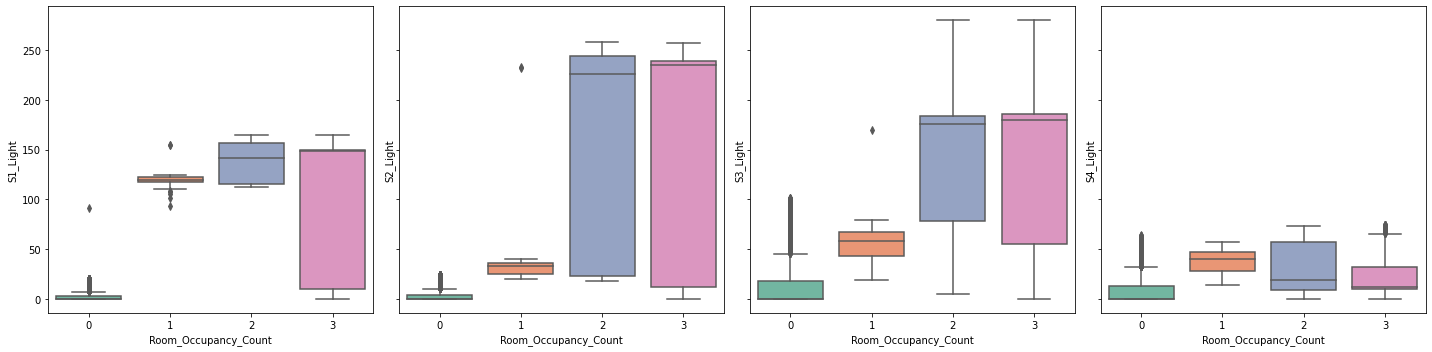

In [62]:
fig, axs = plt.subplots(1, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 5))
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(ax=axs[i], x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy[feature], 
                palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()


# 
### Visualization ( Sounds Sensors ) 

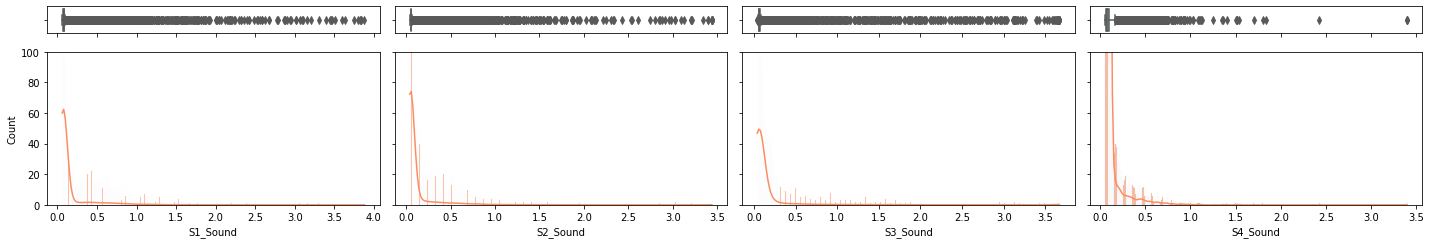

In [63]:
features_to_visualize = ["S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound"]

fig, axs = plt.subplots(2, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 3.5),
                       gridspec_kw={"height_ratios": [.15,.85]})
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(df_occupancy[feature], orient="h", ax=axs[0, i], color='#66c2a5')
    sns.histplot(data=df_occupancy, x=feature, ax=axs[1, i], color='#fc8d62', kde=True)

    axs[0, i].set(xlabel='')
    axs[1, i].set(xlabel=feature)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

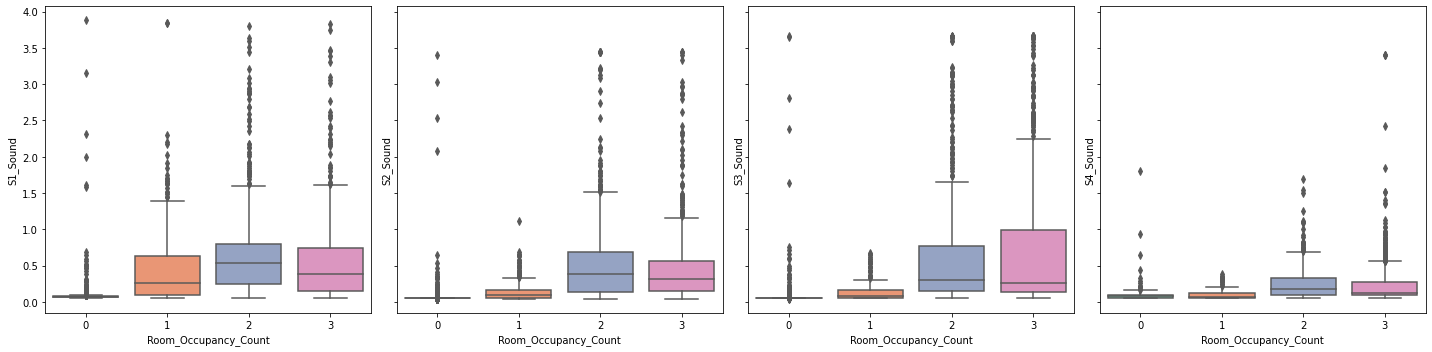

In [64]:
fig, axs = plt.subplots(1, 4,
                       sharex='col', 
                       sharey='row',
                       figsize=(20, 5))
       
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(ax=axs[i], x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy[feature], 
                palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()


# 
### Visualization ( S5_CO2 )

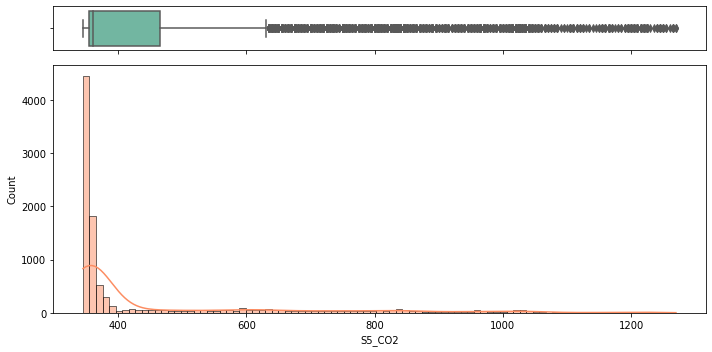

In [65]:
fig, (axs_box, axs_hist) = plt.subplots(2,
                           sharex='col', 
                           sharey='row',
                           figsize=(10, 5),
                           gridspec_kw={"height_ratios": [.15,.85]})
       
sns.boxplot(df_occupancy["S5_CO2"], orient="h", ax=axs_box, color='#66c2a5')
sns.histplot(data=df_occupancy, x="S5_CO2", ax=axs_hist, color='#fc8d62', kde=True)

axs_box.set(xlabel='')
axs_hist.set(xlabel="S5_CO2")

plt.tight_layout()
plt.show()

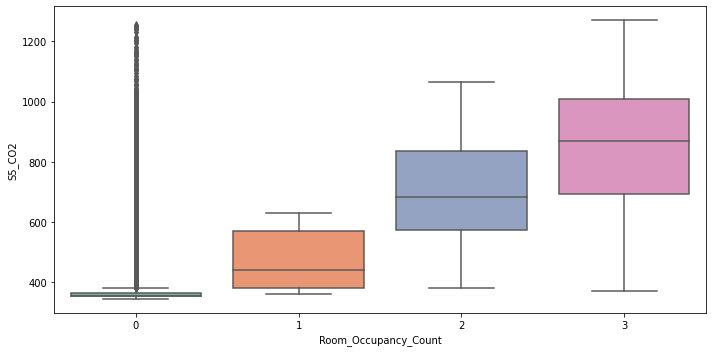

In [66]:
fig, axs = plt.subplots(1, sharex='col', sharey='row', figsize=(10, 5))
       
sns.boxplot(ax=axs, x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy["S5_CO2"], 
            palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

# 
### Visualization ( S5_CO2_Slope )

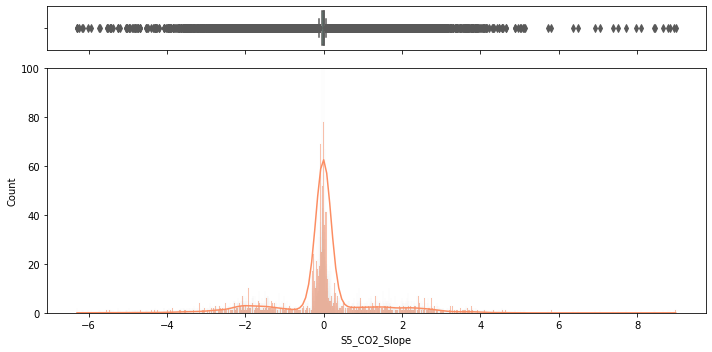

In [67]:
fig, (axs_box, axs_hist) = plt.subplots(2,
                           sharex=True,
                           figsize=(10, 5),
                           gridspec_kw={"height_ratios": [.15,.85]})
       
sns.boxplot(df_occupancy["S5_CO2_Slope"], orient="h", ax=axs_box, color='#66c2a5')
sns.histplot(data=df_occupancy, x="S5_CO2_Slope", ax=axs_hist, color='#fc8d62', kde=True)

axs_box.set(xlabel='')
axs_hist.set(xlabel="S5_CO2_Slope")

plt.ylim(0,100)
plt.tight_layout()
plt.show()

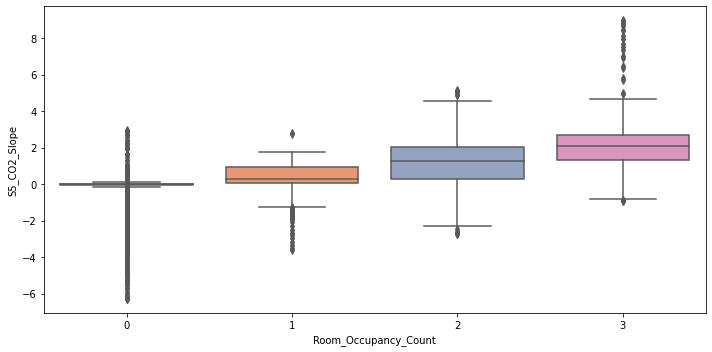

In [68]:
fig, axs = plt.subplots(1, sharex='col', sharey='row', figsize=(10, 5))
       
sns.boxplot(ax=axs, x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy["S5_CO2_Slope"], 
            palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

# 
### Visualization ( S6_PIR )

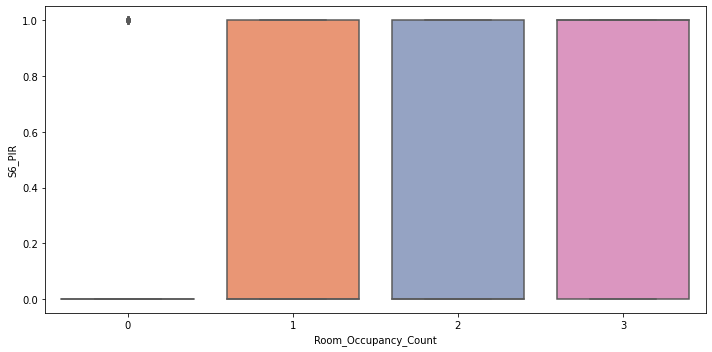

In [69]:
fig, axs = plt.subplots(1, sharex='col', sharey='row', figsize=(10, 5))
       
sns.boxplot(ax=axs, x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy["S6_PIR"], 
            palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

# 
### Visualization ( S7_PIR )

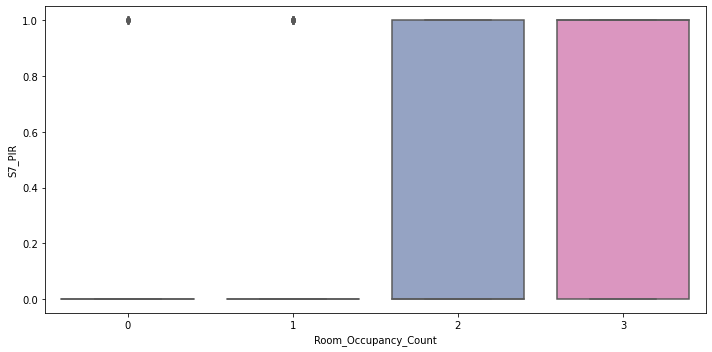

In [70]:
fig, axs = plt.subplots(1, sharex='col', sharey='row', figsize=(10, 5))
       
sns.boxplot(ax=axs, x = df_occupancy['Room_Occupancy_Count'], y = df_occupancy["S7_PIR"], 
            palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])

plt.tight_layout()
plt.show()

**Insights:**
-  Light, Sound and Motion sensors along with Room_Occupancy exhibit temporal patterns throughout the day,  have zero values during the night time and higher values when the room is occupied.
-  The S2_Temp has recorded higher values
-  The sound sensors variable show higher when more than one occupant.

# 
### ----------------------------------------------------------------------------------------------------------------------------------------------------------

# 
# Variables Correlation And Feature Selection:


## LINEAR Assumption:


### Feature Selection:
### (ANOVA – Numeric Predictors vs Room_Occupancy_Count)

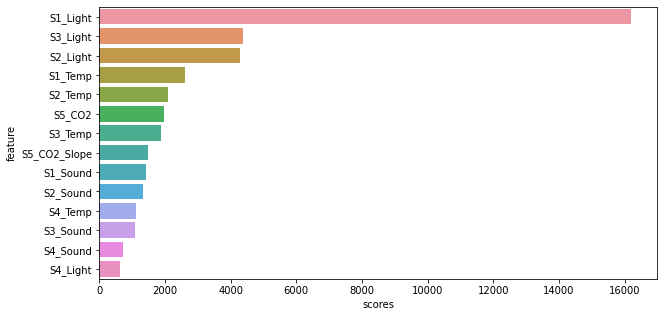

,feature,p-value,scores
0,S1_Light,0.0,16188.975985
1,S3_Light,0.0,4384.458790
2,S2_Light,0.0,4293.604225
3,S1_Temp,0.0,2611.836757
4,S2_Temp,0.0,2100.372099
5,S5_CO2,0.0,1965.146696
6,S3_Temp,0.0,1876.377292
7,S5_CO2_Slope,0.0,1468.167543
8,S1_Sound,0.0,1422.084604
9,S2_Sound,0.0,1336.209925


In [71]:
df_num = df_occupancy[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 
                       'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 
                       'Room_Occupancy_Count']]

class_col = 'Room_Occupancy_Count' 

num_cols = df_num.columns[df_num.columns != class_col]

X_train, X_test, y_train, y_test = train_test_split(df_num[num_cols], 
                                                    df_num[class_col], 
                                                    stratify = df_num[class_col], random_state=1) 

fs = SelectKBest(score_func = f_classif, k='all') # Apply the ANOVA test on all features
fs.fit(X_train, y_train)                          # Run score function on (X, y) and get the appropriate features

fs_nums = pd.DataFrame() 
fs_nums['feature'] = num_cols
fs_nums['p-value'] = fs.pvalues_ 
fs_nums['scores'] = fs.scores_ 

fs_numsSorted = fs_nums.sort_values(by=['scores'], ascending=False)
fs_numsSorted.reset_index(drop=True, inplace=True)
fs_numsSorted

sns.barplot(y = 'feature', x = 'scores', data = fs_numsSorted)
plt.show()

fs_numsSorted[fs_numsSorted['p-value'] < 0.05]


### Feature Selection:
### Linear - (Pearson Correlation–Numeric Predictors vs Room_Occupancy_Count):

>  For numeric features and Room_Occupancy_Count, the most commonly used **Correlation Coefficient** is the Pearson correlation coefficient. It  is a statistical measure that quantifies the strength and direction of a linear relationship between two variables. 

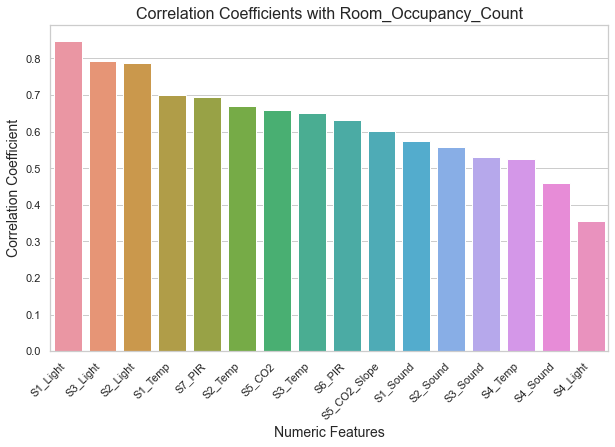

S1_Light        0.849058
S3_Light        0.793081
S2_Light        0.788764
S1_Temp         0.700868
S7_PIR          0.695138
S2_Temp         0.671263
S5_CO2          0.660144
S3_Temp         0.652047
S6_PIR          0.633133
S5_CO2_Slope    0.601105
S1_Sound        0.573748
S2_Sound        0.557853
S3_Sound        0.531685
S4_Temp         0.526509
S4_Sound        0.460287
S4_Light        0.355715
Name: Room_Occupancy_Count, dtype: float64


In [72]:
numeric_features = df_occupancy.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_features.corr()

correlation_with_target = correlation_matrix['Room_Occupancy_Count'].drop('Room_Occupancy_Count')
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target_sorted.index, y=correlation_with_target_sorted.values)

# Customize the plot
plt.title('Correlation Coefficients with Room_Occupancy_Count', fontsize=16)
plt.xlabel('Numeric Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

print(correlation_with_target_sorted)



## NON-LINEAR Assumption:


### Feature Selection:
### Non-Linear - (Mutual Information–All Predictors vs Room_Occupancy_Count)

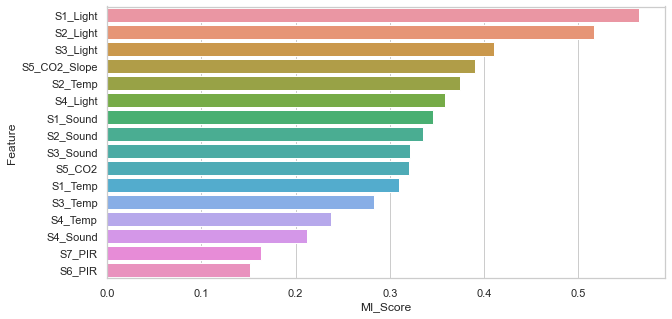

In [73]:

X = df_occupancy.drop(['Room_Occupancy_Count', 'Date', 'Time'], axis=1)
y = df_occupancy['Room_Occupancy_Count']

# Label encode categorical target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Calculate Mutual Information for each feature
mi_scores = mutual_info_classif(X_train, y_train)

# Create a DataFrame to store feature names and their MI scores
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI_Score': mi_scores})

# Sort features based on MI scores
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

sns.barplot(y = 'Feature', x = 'MI_Score', data = mi_df)
plt.show()

# 
## Statistical Tests:

>  1- **t-test(Comparing Two Groups)** -- this hypothesis test will determine if there are differences between the means of two classes(numeric vs categorical)    
>  2- **one-way anova(Comparing Three+ Groups)** -- this hypothesis test will determine if there are differences between the means of several classes(numeric vs categorical)    
>  3- **chi-squared** -- this hypothesis test will determine if features are dependent(categorical vs categorical)

**Null Hypothesis (H0):**  
-  There is no significant difference in the means of the temperature/light/sound variables(four groups)  

**Alternative Hypothesis (Ha):**   
-  At least one of the temperature/light/sound variables(four groups) has a different mean

# 
### Temperature Sensors Statistical Test: 
Using One-Way Anova to dicovering if there is a difference in average, across all values in four groups of Temperature columns(S1_Temp,S2_Temp,S3_Temp,S4_Temp)


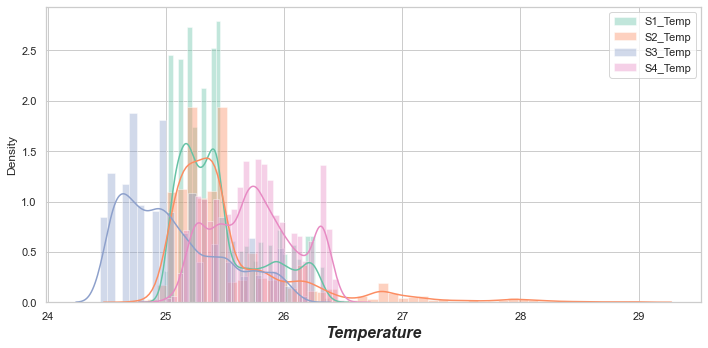

In [74]:
sns.distplot(df_occupancy.S1_Temp, label="S1_Temp", color='#66c2a5', kde=True)
sns.distplot(df_occupancy.S2_Temp, label="S2_Temp", color='#fc8d62', kde=True)
sns.distplot(df_occupancy.S3_Temp, label="S3_Temp", color='#8da0cb', kde=True)
sns.distplot(df_occupancy.S4_Temp, label="S4_Temp", color='#e78ac3', kde=True)
plt.xlabel('Temperature', size=16, fontstyle='italic', weight=900)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
f, p = stats.f_oneway(df_occupancy.S1_Temp, df_occupancy.S2_Temp,df_occupancy.S3_Temp, df_occupancy.S4_Temp)
print(f'f-value : {f}')
print(f'p-value : {p}')

f-value : 4458.430427883466
p-value : 0.0


In [76]:
features_list = ['S1_Temp','S2_Temp','S3_Temp','S4_Temp']

df_melted = pd.melt(df_occupancy, value_vars=features_list, var_name='Group', value_name='Variable')

model = sm.formula.ols('Variable ~ Group', data=df_melted).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

tukey = pairwise_tukeyhsd(endog=df_melted['Variable'], groups=df_melted['Group'], alpha=0.05)

print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
S1_Temp S2_Temp    0.092   0.0  0.0761   0.108   True
S1_Temp S3_Temp  -0.3974   0.0 -0.4133 -0.3815   True
S1_Temp S4_Temp   0.3001   0.0  0.2842   0.316   True
S2_Temp S3_Temp  -0.4894   0.0 -0.5053 -0.4735   True
S2_Temp S4_Temp   0.2081   0.0  0.1922   0.224   True
S3_Temp S4_Temp   0.6975   0.0  0.6816  0.7134   True
-----------------------------------------------------


-  Certain sensors have higher or lower temperatures.
-  The "meandiff" column provides the average difference in values between the compared groups. For example, a positive value for a pair ( S1_Temp vs. S2_Temp) indicates that the mean temperature of S1_Temp is higher than S2_Temp
-  There are significant differences in means between all pairs of temperature sensors.
-  It can be infered the direction of differences from the sign of the mean differences. For instance, if S1_Temp vs. S2_Temp has a positive mean difference, it suggests that S1_Temp tends to have higher values than S2_Temp.

# 
### Light Sensors  Statistical Test: 
Using One-Way Anova to discover if there is a difference in average, across all values in four groups of Light columns(S1_Light,S2_Light,S3_Light,S4_Light)


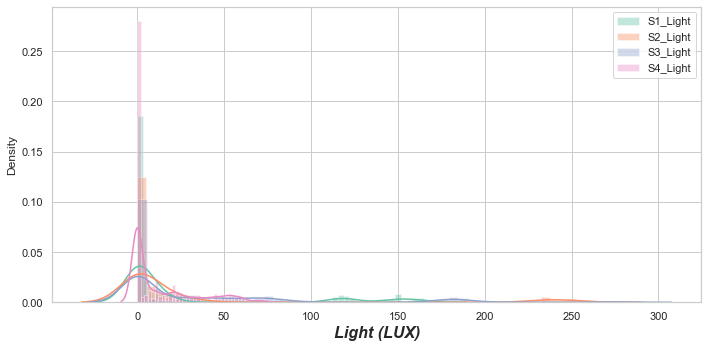

In [77]:
plt.clf() 
sns.distplot(df_occupancy.S1_Light, label="S1_Light", color='#66c2a5', kde=True)
sns.distplot(df_occupancy.S2_Light, label="S2_Light", color='#fc8d62', kde=True)
sns.distplot(df_occupancy.S3_Light, label="S3_Light", color='#8da0cb', kde=True)
sns.distplot(df_occupancy.S4_Light, label="S4_Light", color='#e78ac3', kde=True);
plt.xlabel('Light (LUX)', size=16, fontstyle='italic', weight=900)
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
f, p = stats.f_oneway(df_occupancy.S1_Light, df_occupancy.S2_Light,df_occupancy.S3_Light, df_occupancy.S4_Light)
print(f'f-value : {f}')
print(f'p-value : {p}')

f-value : 278.39240105576897
p-value : 7.023925657885299e-179


In [79]:
features_list = ['S1_Light','S2_Light','S3_Light','S4_Light']

df_melted = pd.melt(df_occupancy, value_vars=features_list, var_name='Group', value_name='Variable')

model = sm.formula.ols('Variable ~ Group', data=df_melted).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

tukey = pairwise_tukeyhsd(endog=df_melted['Variable'], groups=df_melted['Group'], alpha=0.05)

print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
S1_Light S2_Light   0.5712 0.8646  -1.3156   2.4581  False
S1_Light S3_Light   8.8034    0.0   6.9166  10.6903   True
S1_Light S4_Light -12.2248    0.0 -14.1117 -10.3379   True
S2_Light S3_Light   8.2322    0.0   6.3454  10.1191   True
S2_Light S4_Light  -12.796    0.0 -14.6829 -10.9092   True
S3_Light S4_Light -21.0282    0.0 -22.9151 -19.1414   True
----------------------------------------------------------


-  Light sensors have higher or lower levels
-  The adjusted p-values for all pairwise comparisons, except for S1_Light vs. S2_Light, are reported as 0.0, indicating high statistical significance. This implies that there are significant differences in means between the majority of pairs of light sensors.
-  The "meandiff" column provides the average difference in values between the compared groups. For example, a positive value for a pair (S1_Light vs. S3_Light) indicates that the mean light level for S1_Light is higher than S3_Light.
-  Since the majority of entries in the "reject" column are True, it will be concluded that there are significant differences in means between most pairs of light sensors.
-  It can be infered the direction of differences from the sign of the mean differences. For instance, if S1_Light vs. S3_Light has a positive mean difference, it suggests that S1_Light tends to have higher light levels than S3_Light.

# 
###  Sound Sensors Statistical Test: 
Using One-Way Anova to discover if there is a difference in average, across all values in four groups of Sound columns(S1_Sound,S2_Sound,S3_Sound,S4_Sound)


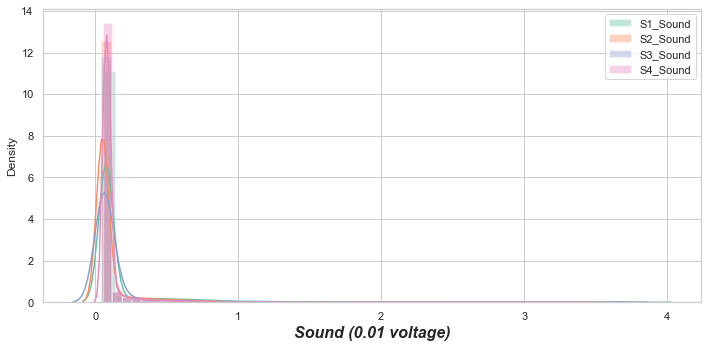

In [80]:
plt.clf() 
sns.distplot(df_occupancy.S1_Sound, label="S1_Sound", color='#66c2a5', kde=True)
sns.distplot(df_occupancy.S2_Sound, label="S2_Sound", color='#fc8d62', kde=True)
sns.distplot(df_occupancy.S3_Sound, label="S3_Sound", color='#8da0cb', kde=True)
sns.distplot(df_occupancy.S4_Sound, label="S4_Sound", color='#e78ac3', kde=True);
plt.xlabel('Sound (0.01 voltage)', size=16, fontstyle='italic', weight=900)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
f, p = stats.f_oneway(df_occupancy.S1_Sound, df_occupancy.S2_Sound,df_occupancy.S3_Sound, df_occupancy.S4_Sound);
print(f'f-value : {f}')
print(f'p-value : {p}')

f-value : 106.04723802697454
p-value : 2.1835783091369963e-68


In [82]:
features_list = ['S1_Sound','S2_Sound','S3_Sound','S4_Sound']

df_melted = pd.melt(df_occupancy, value_vars=features_list, var_name='Group', value_name='Variable')

model = sm.formula.ols('Variable ~ Group', data=df_melted).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

tukey = pairwise_tukeyhsd(endog=df_melted['Variable'], groups=df_melted['Group'], alpha=0.05)

print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
S1_Sound S2_Sound  -0.0481    0.0 -0.0589 -0.0373   True
S1_Sound S3_Sound  -0.0101 0.0778 -0.0208  0.0007  False
S1_Sound S4_Sound  -0.0643    0.0 -0.0751 -0.0536   True
S2_Sound S3_Sound   0.0381    0.0  0.0273  0.0488   True
S2_Sound S4_Sound  -0.0162 0.0006  -0.027 -0.0054   True
S3_Sound S4_Sound  -0.0543    0.0 -0.0651 -0.0435   True
--------------------------------------------------------


-  Sounds sensors have higher or lower levels
-  The adjusted p-values for all pairwise comparisons, except for S1_Sound vs. S3_Sound, are reported as 0.0, indicating high statistical significance. This implies that there are significant differences in means between the majority of pairs of sound sensors.
-  The "meandiff" column provides the average difference in values between the compared groups. For example, a negative value for a pair (S1_Sound vs. S2_Sound) indicates that the mean sound level for S1_Sound is lower than S2_Sound.
-  The "reject" column indicates whether reject the null hypothesis of equal means. Since the majority of entries in the "reject" column are True, there are significant differences in means between most pairs of sound sensors.
-  It can be infered the direction of differences from the sign of the mean differences. For instance, if S1_Sound vs. S2_Sound has a negative mean difference, it suggests that S1_Sound tends to have lower sound levels than S2_Sound.

In the context of the provided ANOVA test results:
-  large f-value with a p-value of 0.0
-  the null hypothesis will be rejected.   

This suggests that **there is strong evidence to conclude that there is a significant difference in the means** of the variables. 

**At least one of the temperature/light/sound variables has a different average value compared to the others**

# 
## Bivariate Statistics:
  It deals with relationships between two variables, and how the features affect some labels. 
- There are three types of **Bivariate statistics**:    
    >    1- **(NUM/NUM):** Numeric to Numeric relationship    
    >    2- **(CAT/NUM):** Categorical to Numeric relationship    
    >    3- **(CAT/CAT):** Categorical to Categorical relationship    

# 
## Bivariate CAT/NUM  
## One-Way ANOVA Test:   
**Examining how the occupancy impacts sensors values.**
- **(CAT/NUM):** Room_Occupancy_Count **VS** (S1_Temp , S2_Temp , S3_Temp , S4_Temp , S1_Light , S2_Light , S3_Light ,     S4_Light , S1_Sound , S2_Sound , S3_Sound , S4_Sound , S5_CO2 , S5_CO2_Slope)  

**Null Hypothesis (H0):**  
-  The means of Room_Occupancy_Count are equal across different levels of the specified features  

**Alternative Hypothesis (Ha):**   
-  there is a significant difference in means

### Bivariate  - ANOVA Test:   
**S5_CO2** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

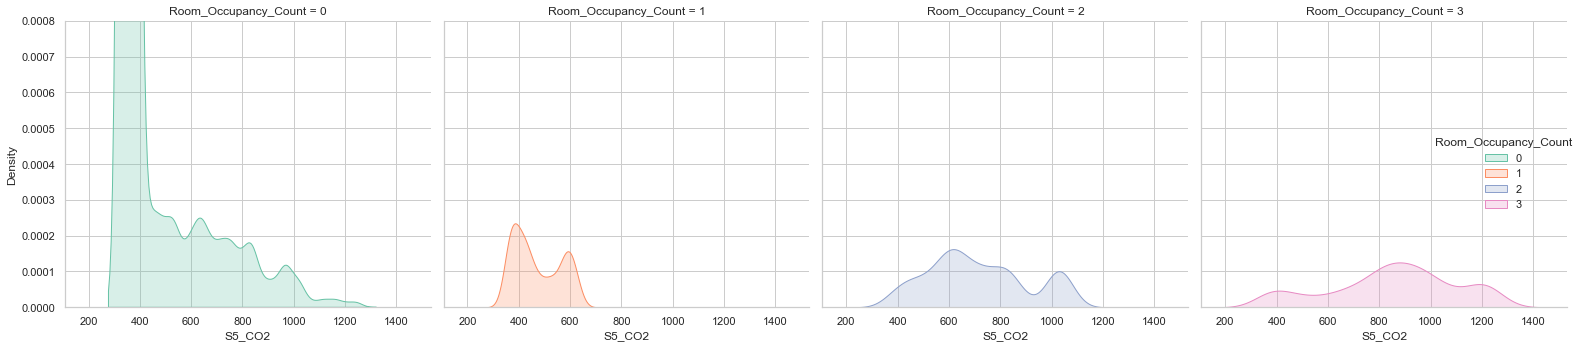

In [83]:
plt.clf() 
sns.displot(data=df_occupancy, x="S5_CO2", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);

plt.ylim(0,.0008)
plt.tight_layout()
plt.show()

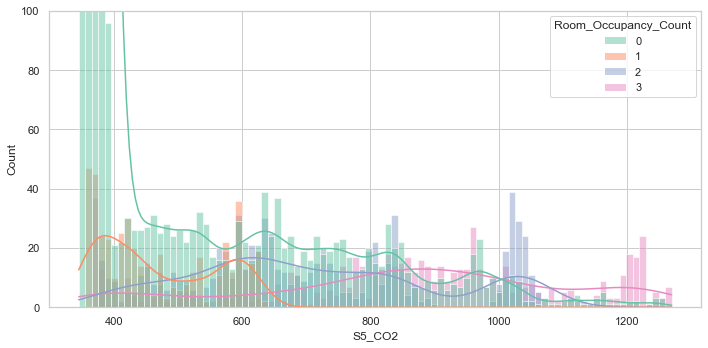

In [84]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S5_CO2", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);

plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [85]:
anova_('S5_CO2')

F_onewayResult(statistic=2689.7587234168395, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S5_CO2_Slope** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

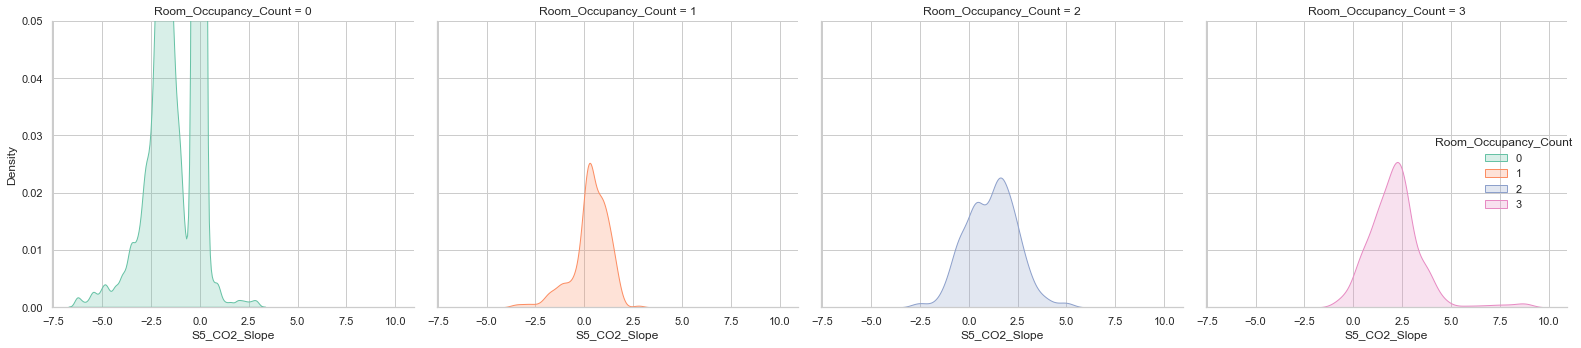

In [86]:
plt.clf() 
sns.displot(data=df_occupancy, x="S5_CO2_Slope", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.05)
plt.tight_layout()
plt.show()

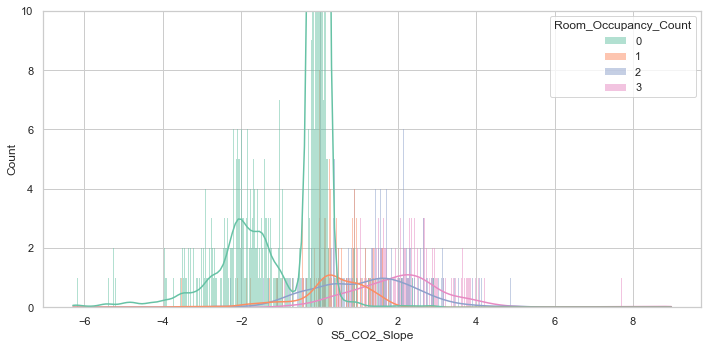

In [87]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S5_CO2_Slope", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [88]:
anova_('S5_CO2_Slope')

F_onewayResult(statistic=1927.1011299664176, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S1_Temp** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

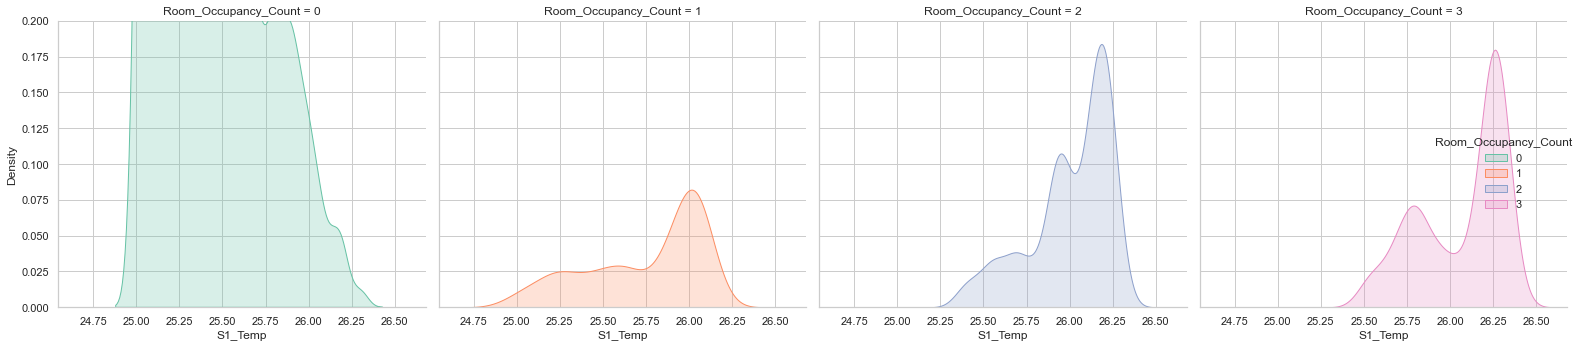

In [89]:
plt.clf() 
sns.displot(data=df_occupancy, x="S1_Temp", hue="Room_Occupancy_Count", kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);

plt.ylim(0,.2)
plt.tight_layout()
plt.show()

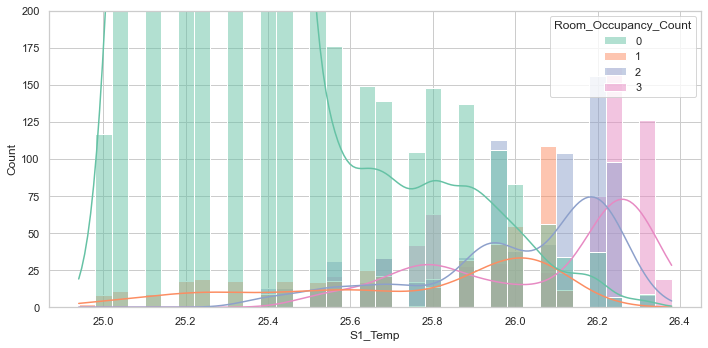

In [90]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S1_Temp", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,200)
plt.tight_layout()
plt.show()

In [91]:
anova_('S1_Temp')

F_onewayResult(statistic=3515.813553612012, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S2_Temp** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

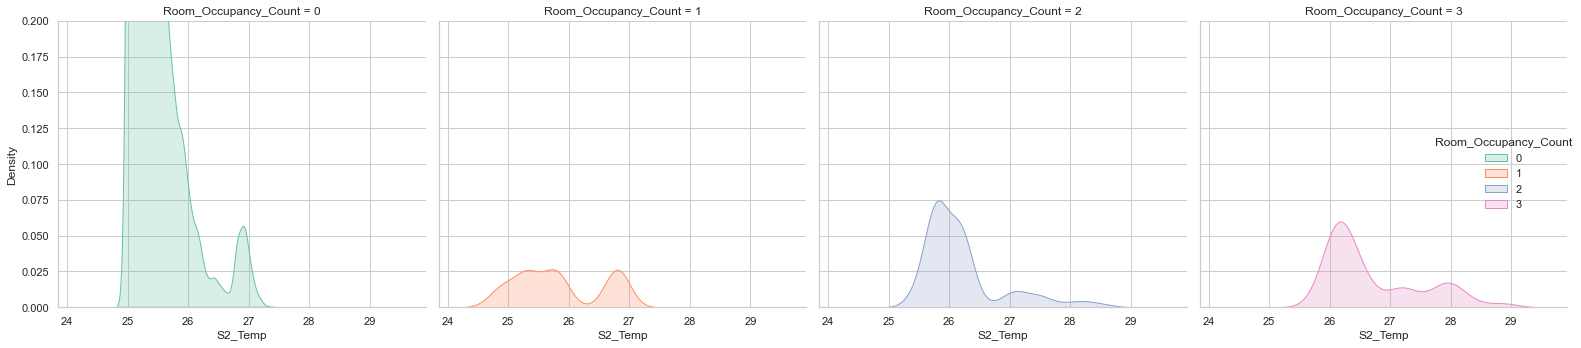

In [92]:
plt.clf() 
sns.displot(data=df_occupancy, x="S2_Temp", hue="Room_Occupancy_Count", kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.2)
plt.tight_layout()
plt.show()

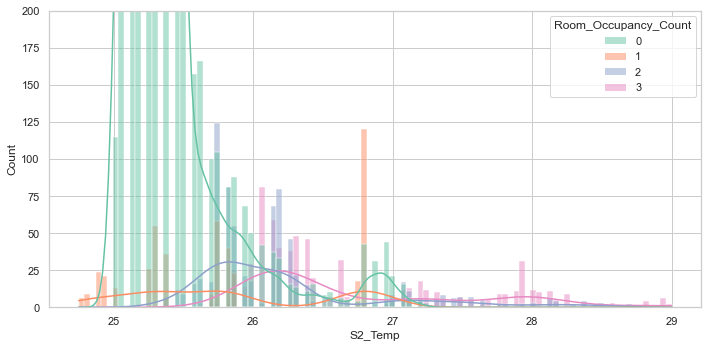

In [93]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S2_Temp", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,200)
plt.tight_layout()
plt.show()

In [94]:
anova_('S2_Temp')

F_onewayResult(statistic=2774.965502971935, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S3_Temp** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

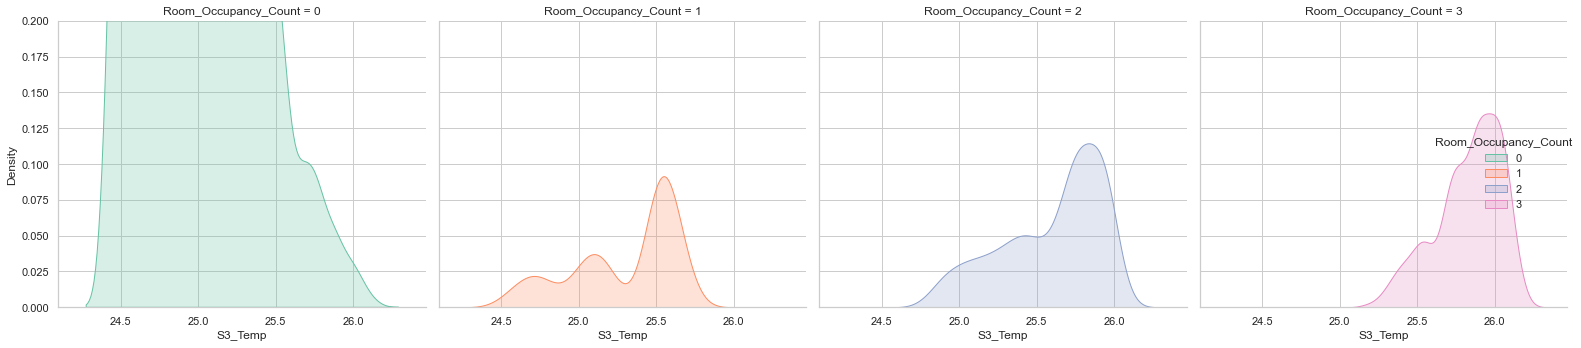

In [95]:
plt.clf() 
sns.displot(data=df_occupancy, x="S3_Temp", hue="Room_Occupancy_Count", kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.2)
plt.tight_layout()
plt.show()

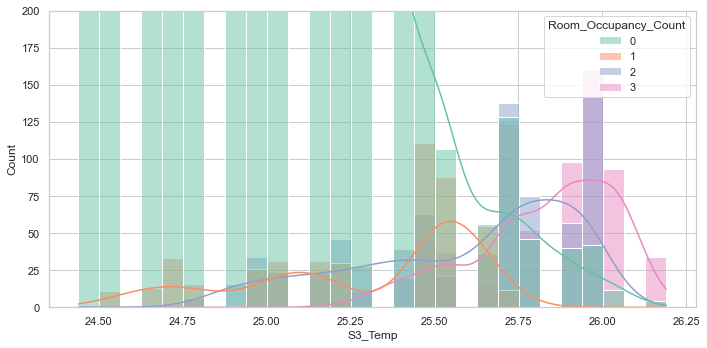

In [96]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S3_Temp", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,200)
plt.tight_layout()
plt.show()

In [97]:
anova_('S3_Temp')

F_onewayResult(statistic=2516.2398373741366, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S4_Temp** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

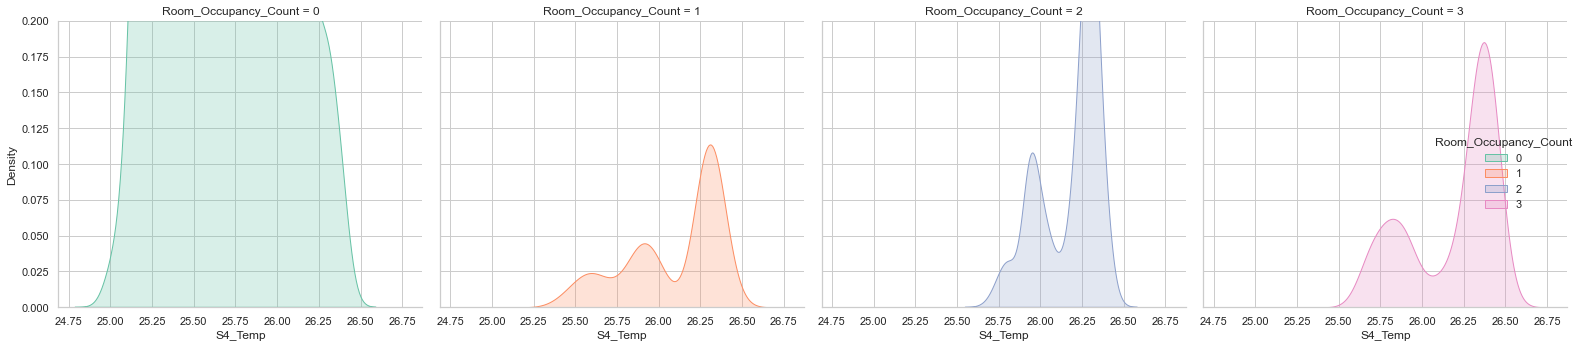

In [98]:
plt.clf() 
sns.displot(data=df_occupancy, x="S4_Temp", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.2)
plt.tight_layout()
plt.show()

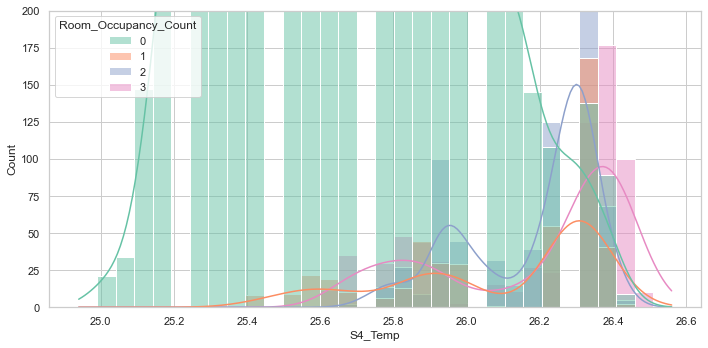

In [99]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S4_Temp", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,200)
plt.tight_layout()
plt.show()

In [100]:
anova_('S4_Temp')

F_onewayResult(statistic=1485.6358862104928, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S1_Light** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

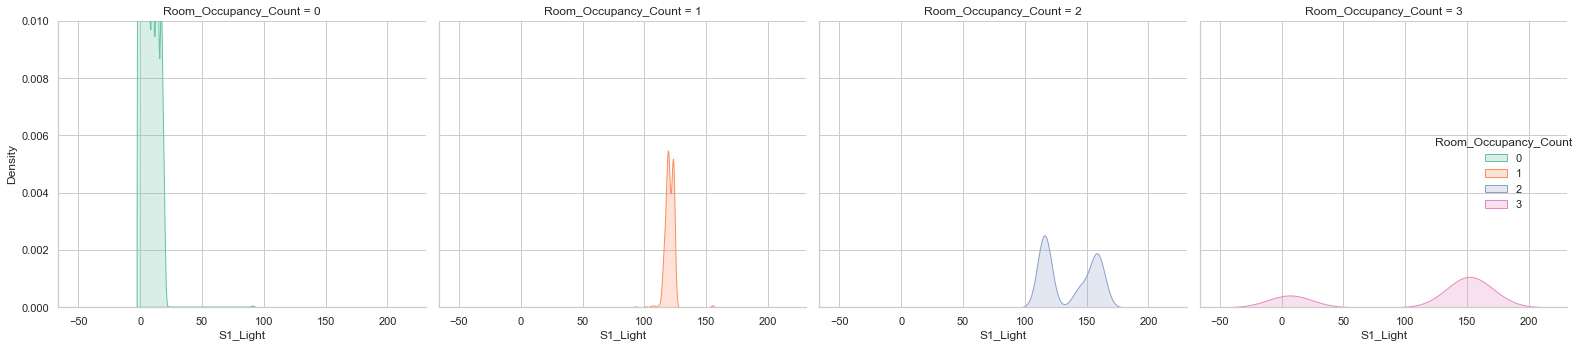

In [101]:
plt.clf() 
sns.displot(data=df_occupancy, x="S1_Light", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.01)
plt.tight_layout()
plt.show()

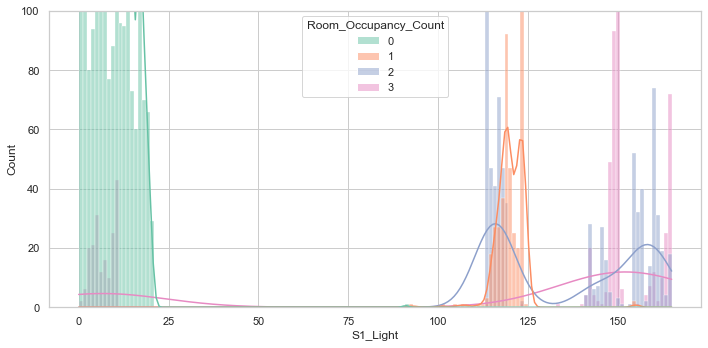

In [102]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S1_Light", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [103]:
anova_('S1_Light')

F_onewayResult(statistic=22393.540766352362, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S2_Light** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

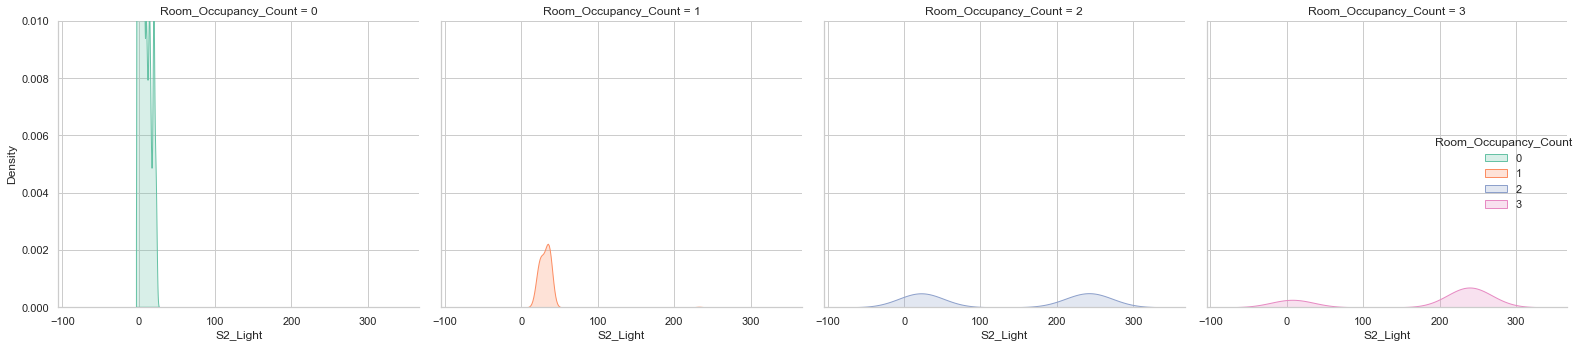

In [104]:
plt.clf() 
sns.displot(data=df_occupancy, x="S2_Light", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.01)
plt.tight_layout()
plt.show()

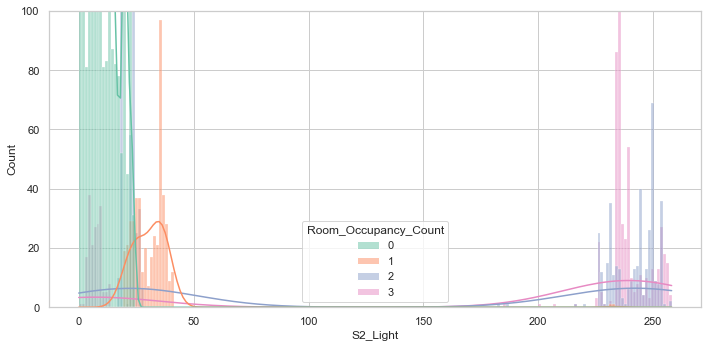

In [105]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S2_Light", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [106]:
anova_('S2_Light')

F_onewayResult(statistic=5862.045970873254, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S3_Light** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

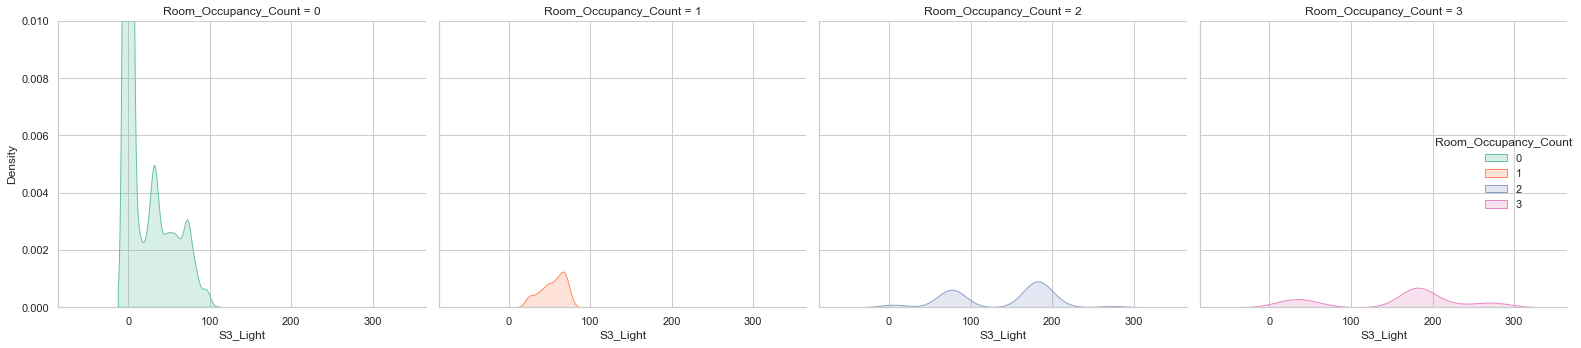

In [107]:
plt.clf() 
sns.displot(data=df_occupancy, x="S3_Light", hue="Room_Occupancy_Count", kind='kde', 
            col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.01)
plt.tight_layout()
plt.show()

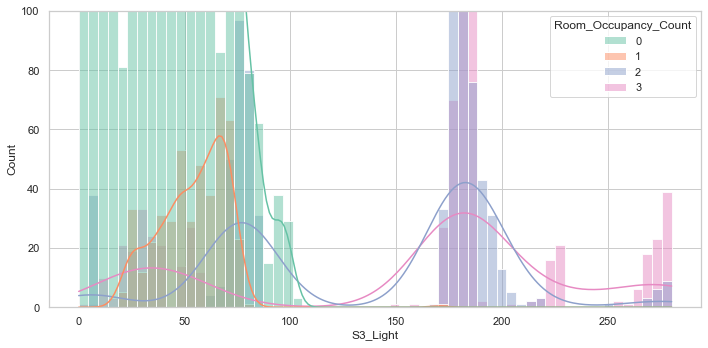

In [108]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S3_Light", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [109]:
anova_('S3_Light')

F_onewayResult(statistic=6092.5182166646455, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S4_Light** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

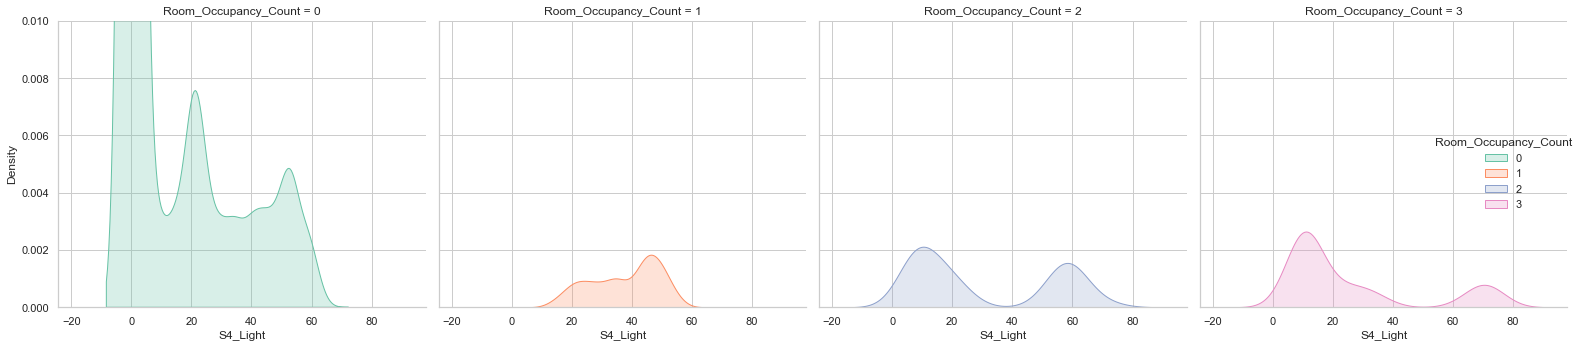

In [110]:
plt.clf() 
sns.displot(data=df_occupancy, x="S4_Light", hue="Room_Occupancy_Count", kind='kde', 
            col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.01)
plt.tight_layout()
plt.show()

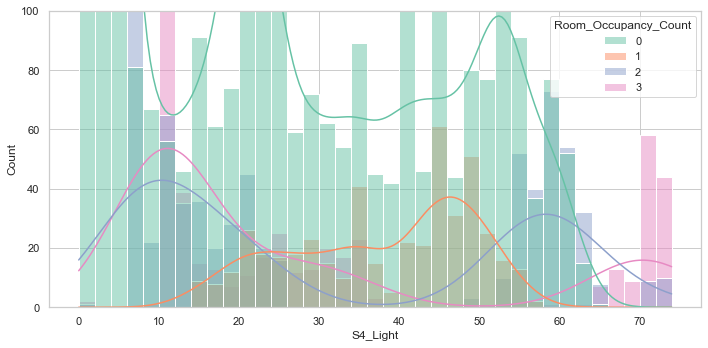

In [111]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S4_Light", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [112]:
anova_('S4_Light')

F_onewayResult(statistic=785.911759762542, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S1_Sound** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

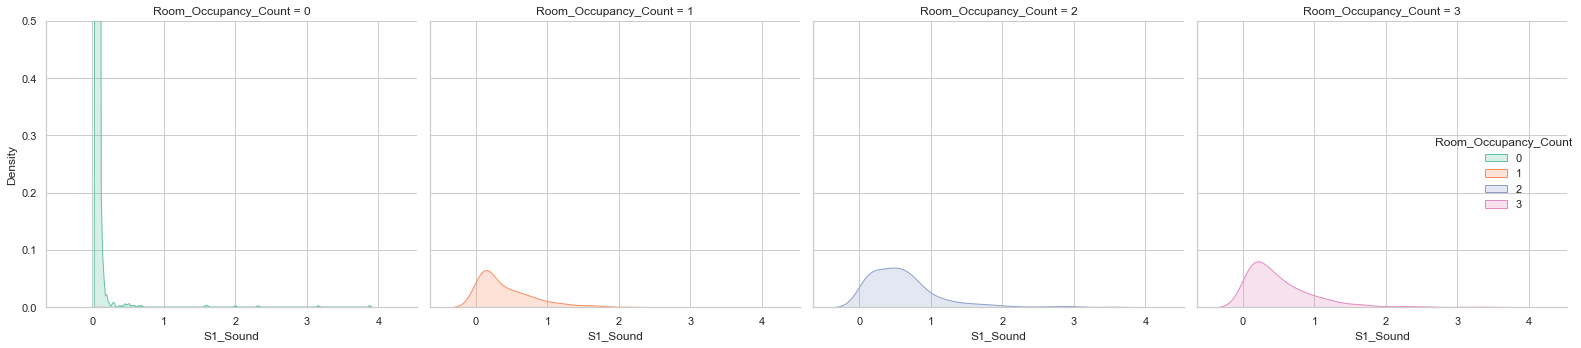

In [113]:
plt.clf() 
sns.displot(data=df_occupancy, x="S1_Sound", hue="Room_Occupancy_Count", kind='kde', 
            col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.5)
plt.tight_layout()
plt.show()

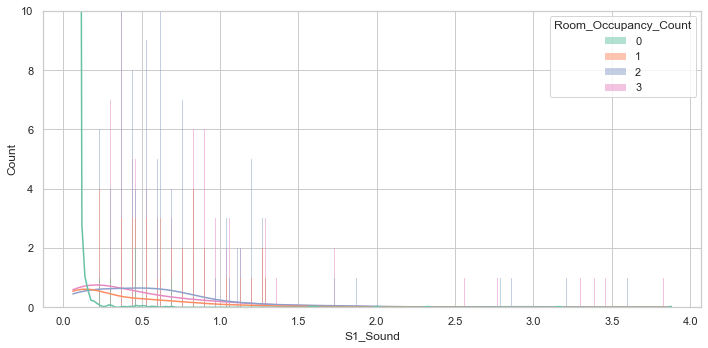

In [114]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S1_Sound", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [115]:
anova_('S1_Sound')

F_onewayResult(statistic=1987.3822249923078, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S2_Sound** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

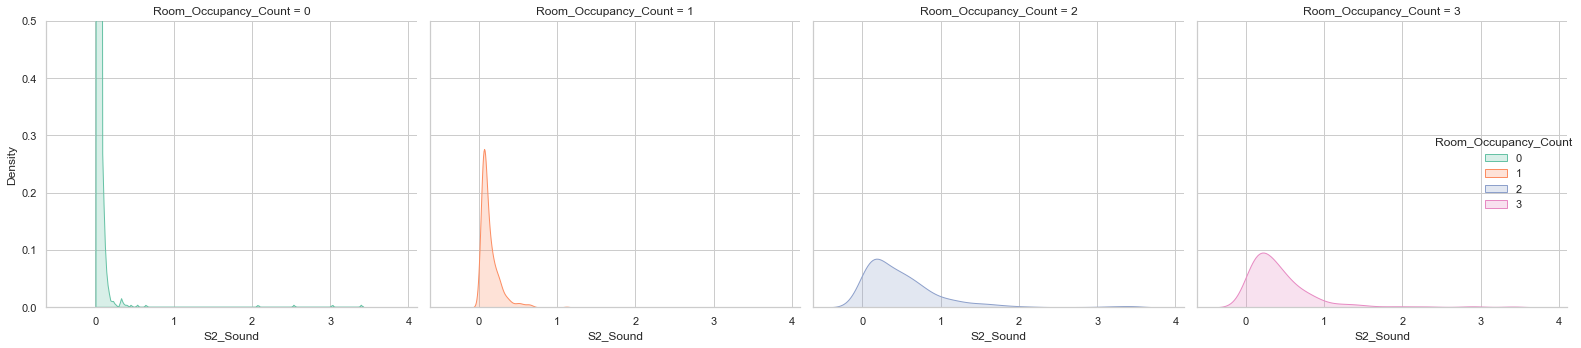

In [116]:
plt.clf() 
sns.displot(data=df_occupancy, x="S2_Sound", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.5)
plt.tight_layout()
plt.show()

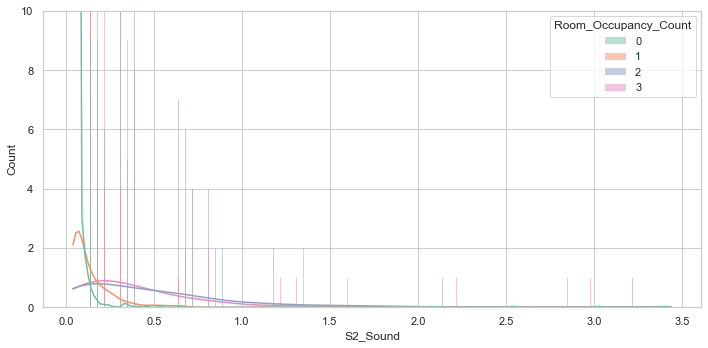

In [117]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S2_Sound", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [118]:
anova_('S2_Sound')

F_onewayResult(statistic=1762.2562608822018, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S3_Sound** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

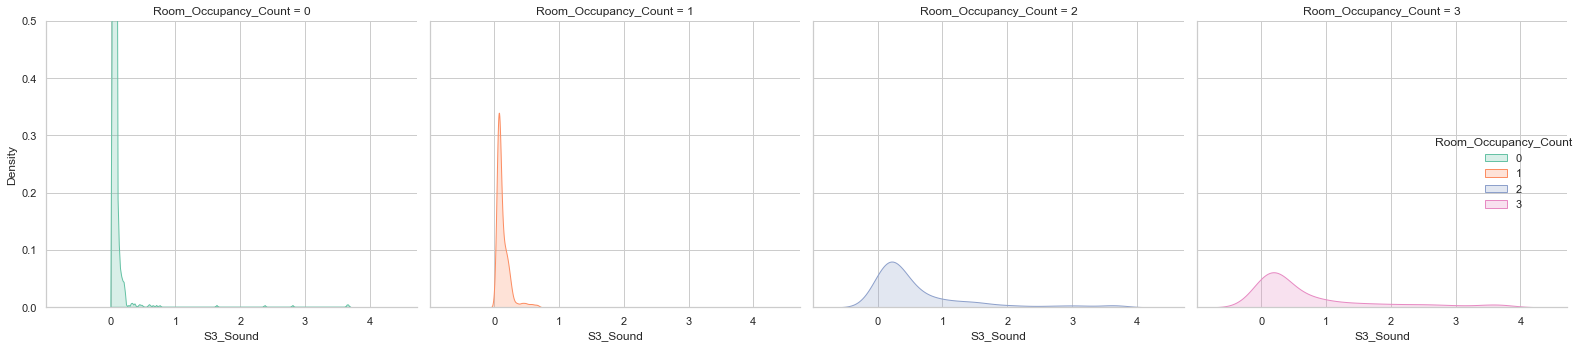

In [119]:
plt.clf() 
sns.displot(data=df_occupancy, x="S3_Sound", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.5)
plt.tight_layout()
plt.show()

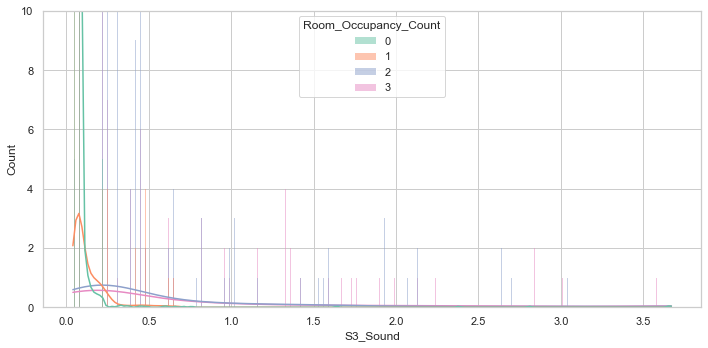

In [120]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S3_Sound", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [121]:
anova_('S3_Sound')

F_onewayResult(statistic=1413.4851682771603, pvalue=0.0)

### Bivariate  - ANOVA Test:   
**S4_Sound** vs **Room_Occupancy_Count**

<Figure size 720x360 with 0 Axes>

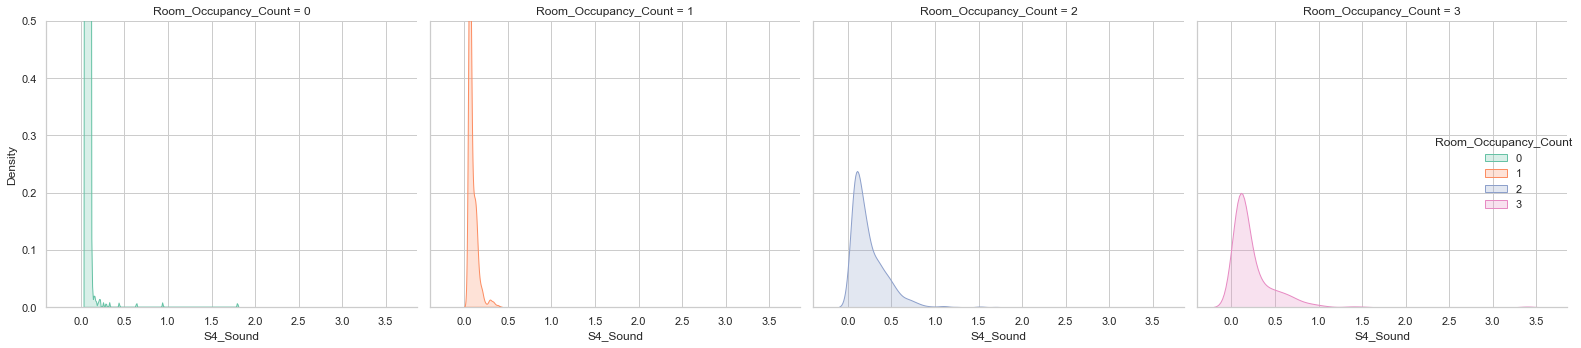

In [122]:
plt.clf() 
sns.displot(data=df_occupancy, x="S4_Sound", hue="Room_Occupancy_Count", 
            kind='kde', col="Room_Occupancy_Count", palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], fill = True);
plt.ylim(0,.5)
plt.tight_layout()
plt.show()

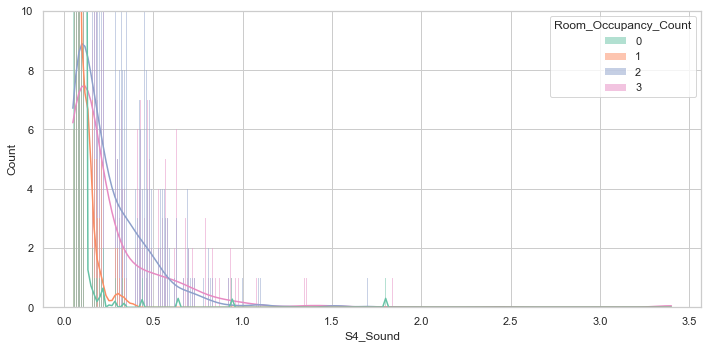

In [123]:
plt.clf() 
sns.histplot(data=df_occupancy, x="S4_Sound", hue="Room_Occupancy_Count", 
             kde=True, palette=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']);
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [124]:
anova_('S4_Sound')

F_onewayResult(statistic=988.8313307678422, pvalue=0.0)

**Anova Test Result:**  
-  A p-value of 0.0 indicates that the null hypothesis should be rejected
-  There is strong evidence that there is a significant difference in the means of the all features levels across different room occupancy counts
-  This implies that these sensor variables can be important features for predicting or understanding room occupancy.

# 
## Bivariate CAT/CAT
## Chi_square Test:
**Let's study dependency of categorical features to the label Room_Occupancy_Count**        
- **(CAT/CAT):** Room_Occupancy_Count **VS** (Date , Time, S6_PIR, S7_PIR)

### Time feature Encoding

-  It is necessary to transform the Time categorical values into the relevant interval ones. Takes into account how many times, time value is present in relation with a range time of the day.

In [125]:
bins = ['00:00:01', '07:00:00', '12:00:00','17:00:00', '21:00:00', '23:59:59']
dictLabels = {1:'Midnight', 2:'Moring', 3:'Afternoon', 4:'Evening', 5:'Night'}

s = pd.to_timedelta(pd.to_datetime(df_occupancy['Time']).dt.time.astype(str))
df_occupancy['Time_Of_Day'] = pd.cut(s, bins = pd.to_timedelta(bins), labels=dictLabels.values(), ordered=False)

df_occupancy['Time_of_Day_Num'] = pd.cut(s, bins = pd.to_timedelta(bins), labels=dictLabels.keys(), ordered=False)

In [126]:
show(df_occupancy)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


# 
## Chi-Squre test:
-  This statistical test is used to determine the association between two categorical variables
-  It is based on difference between the observed frequencies of Room_Occupancy_Count and the expected frequencies
-  It returns a probability, zero shows complete dependency and one shows complete independency
-  It can be used to select the best categorical features for Room_Occupancy_Count.  

**Null Hypothesis (H0):**  
-  There is no significant association between Room_Occupancy_Count and each of (Date , Time, S6_PIR, S7_PIR), they are independent or The distribution of room occupancy counts is independent of them.

**Alternative Hypothesis (Ha):**   
-  There is a significant association between Room_Occupancy_Count and each of (Date , Time, S6_PIR, S7_PIR), they are dependent or The distribution of room occupancy counts is dependent on them.

### Bivariate  - Chi2 Test:
**Date** Vs **Room_Occupancy_Count**

In [127]:
chi2_('Date')

('p value : 0.0', 'Date is correlated to Room_Occupancy_Count')

### Bivariate  - Chi2 Test:
**Time** Vs **Room_Occupancy_Count**

In [128]:
chi2_('Time_Of_Day')

('p value : 0.0', 'Time_Of_Day is correlated to Room_Occupancy_Count')

### Bivariate  - Chi2 Test:
**S6_PIR** Vs **Room_Occupancy_Count**

In [129]:
chi2_('S6_PIR')

('p value : 0.0', 'S6_PIR is correlated to Room_Occupancy_Count')

### Bivariate  - Chi2 Test:
**S7_PIR** Vs **Room_Occupancy_Count**

In [130]:
chi2_('S7_PIR')

('p value : 0.0', 'S7_PIR is correlated to Room_Occupancy_Count')

## Visualization
**Date** Vs **Room_Occupancy_Count**

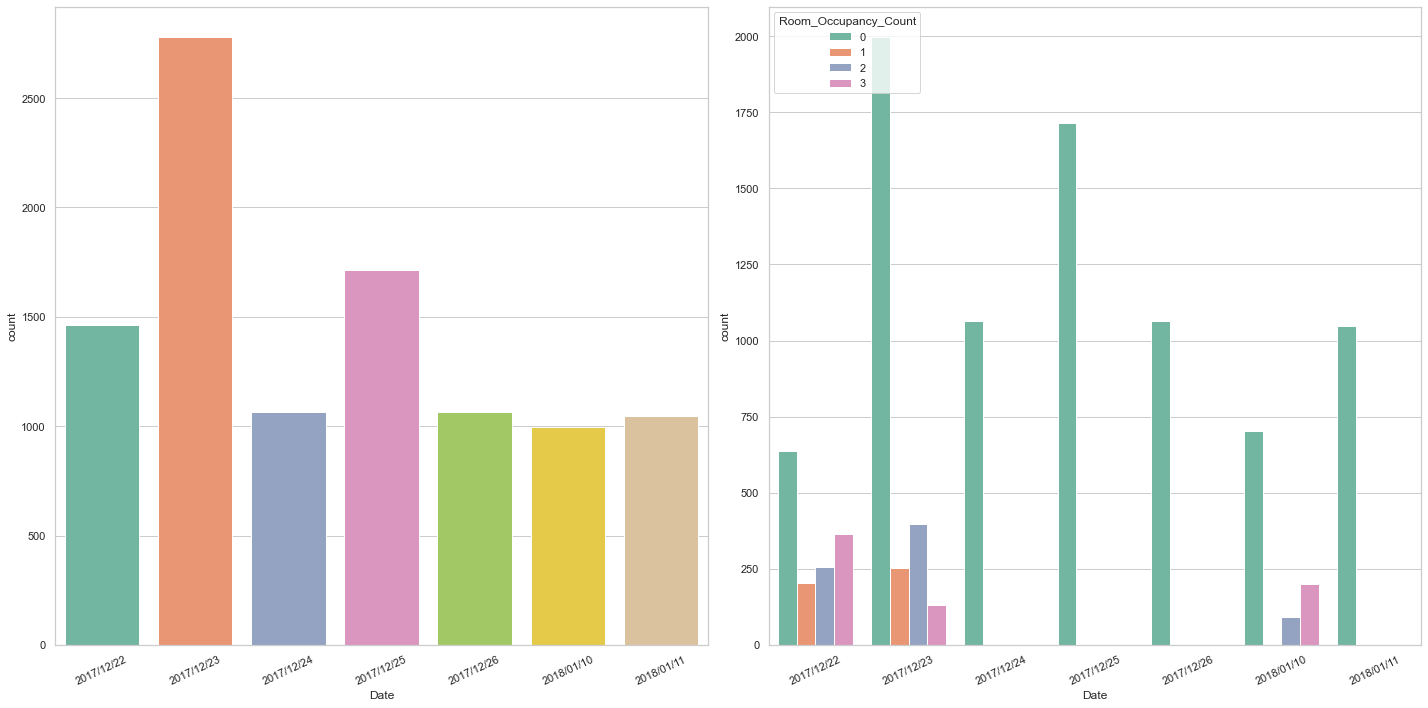

In [131]:
plt.rcParams["figure.figsize"] = [20.00, 10]
f, axes = plt.subplots(1, 2)
viz = sns.countplot(x = 'Date', data = df_occupancy, ax=axes[0], palette=sns.color_palette('Set2'))
viz2 = sns.countplot(x = 'Date', hue = 'Room_Occupancy_Count', data = df_occupancy, 
                     ax=axes[1], palette=sns.color_palette('Set2'))
viz.set_xticklabels(viz.get_xticklabels(), rotation = 25)
viz2.set_xticklabels(viz2.get_xticklabels(), rotation = 25)
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

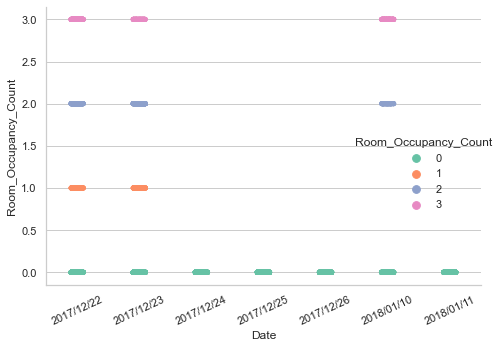

In [132]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='Date', y='Room_Occupancy_Count', 
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));
viz.set_xticklabels(rotation = 25)
plt.tight_layout()
plt.show()

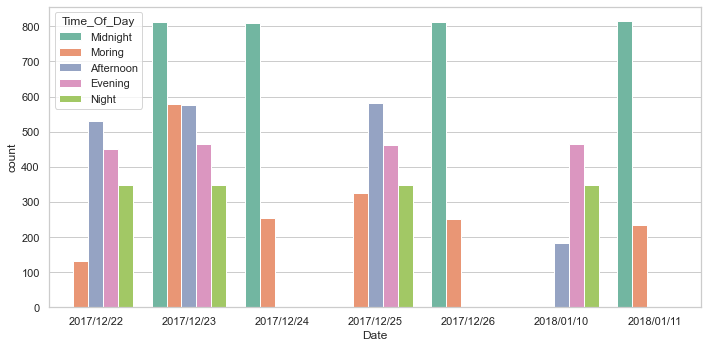

In [133]:
plt.rcParams["figure.figsize"] = [10, 5]
f, axes = plt.subplots()
sns.countplot(x = 'Date', hue = 'Time_Of_Day', data = df_occupancy, 
              ax=axes, palette=sns.color_palette('Set2'))
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

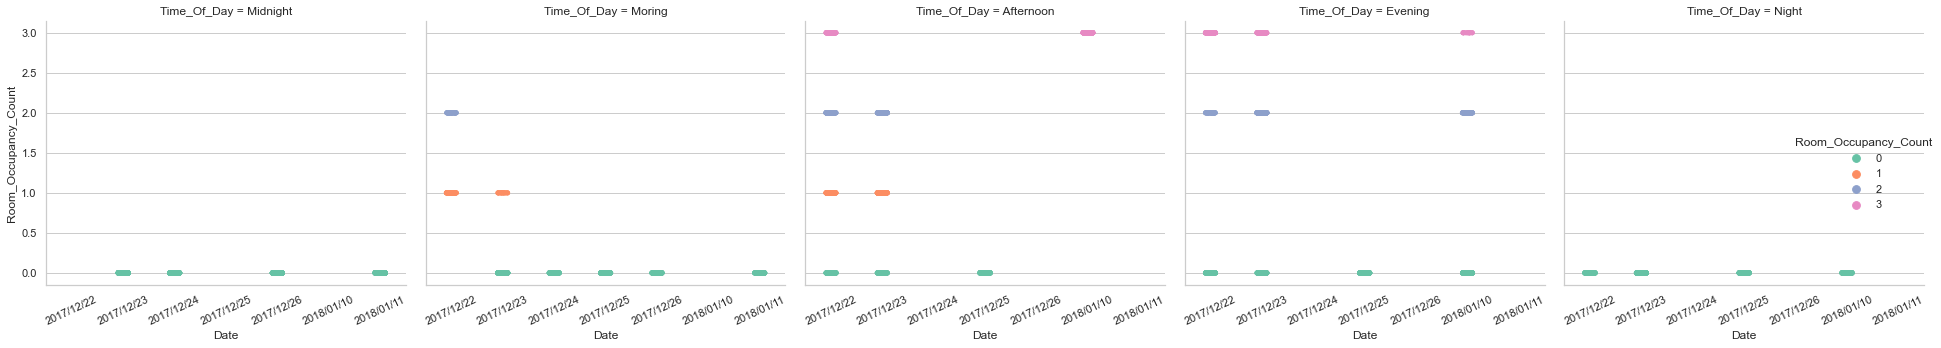

In [134]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='Date', y='Room_Occupancy_Count', 
                  col = 'Time_Of_Day',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));
viz.set_xticklabels(rotation = 25)

viz.figure.savefig("DateVsTime.png")

plt.tight_layout()
plt.show()

## Visualization
**Time** Vs **Room_Occupancy_Count**

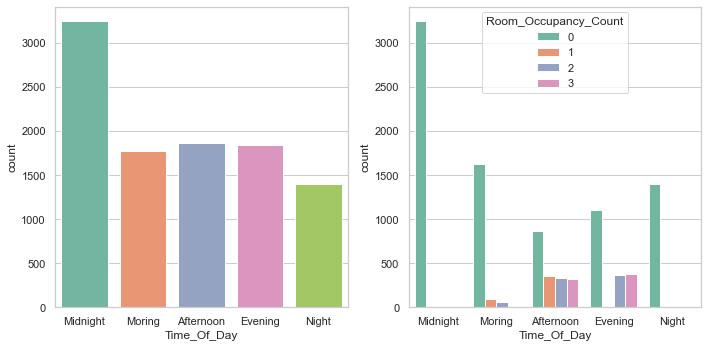

In [135]:
plt.rcParams["figure.figsize"] = [10, 5]
f, axes = plt.subplots(1, 2)
sns.countplot(x = 'Time_Of_Day', data = df_occupancy, ax=axes[0], palette=sns.color_palette('Set2'))
sns.countplot(x = 'Time_Of_Day', hue = 'Room_Occupancy_Count', data = df_occupancy, 
              ax=axes[1], palette=sns.color_palette('Set2'))
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

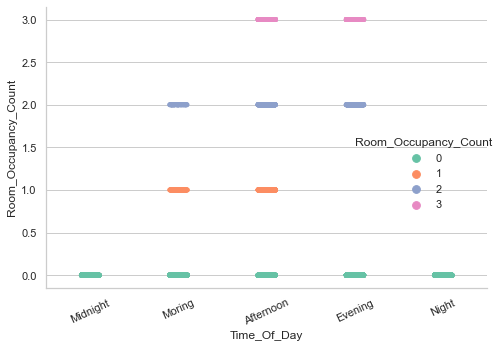

In [136]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='Time_Of_Day', y='Room_Occupancy_Count', 
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));
viz.set_xticklabels(rotation = 25)
plt.tight_layout()
plt.show()

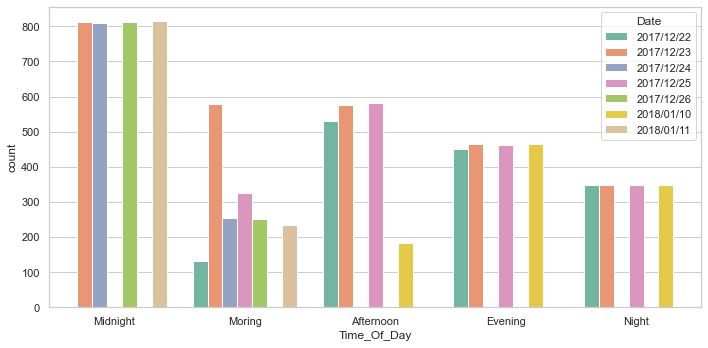

In [137]:
plt.rcParams["figure.figsize"] = [10, 5]
f, axes = plt.subplots()
sns.countplot(x = 'Time_Of_Day', hue = 'Date', data = df_occupancy, 
              ax=axes, palette=sns.color_palette('Set2'))
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

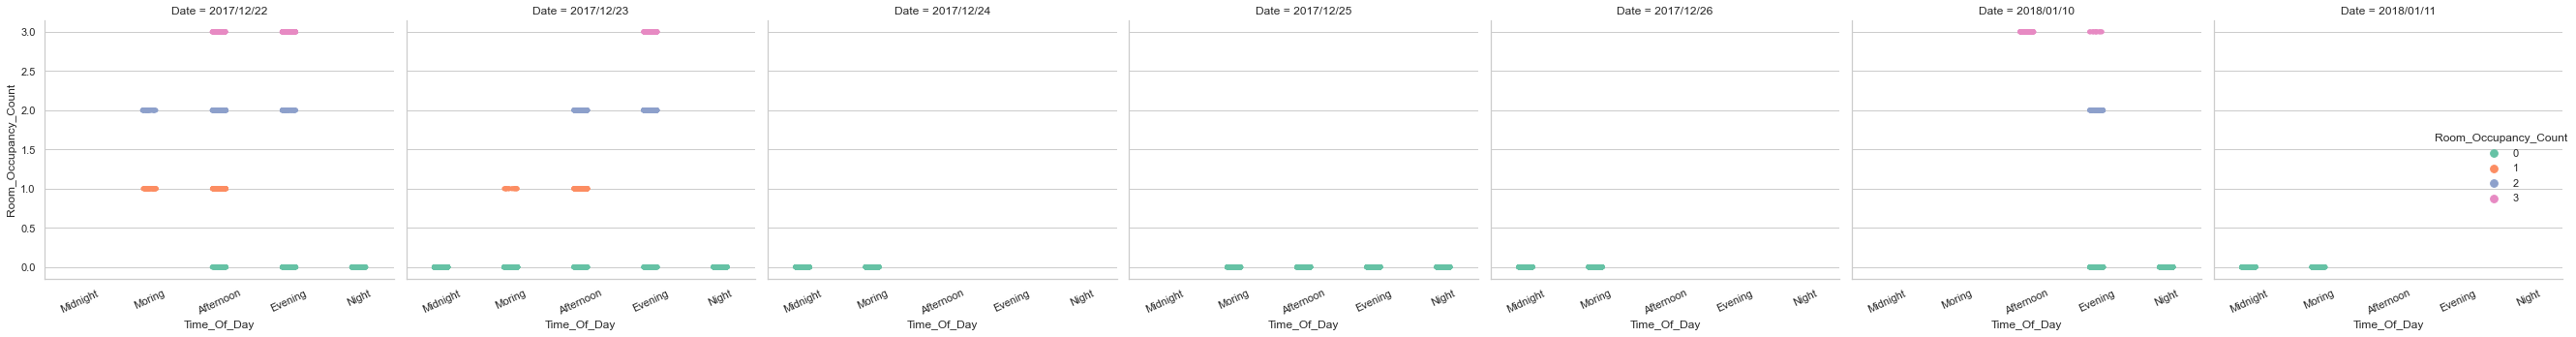

In [138]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='Time_Of_Day', y='Room_Occupancy_Count', 
                  col = 'Date',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));
viz.set_xticklabels(rotation = 25)

viz.figure.savefig("TimeVsDate.png")

plt.tight_layout()
plt.show()

## Visualization
**S6_PIR** Vs **Room_Occupancy_Count**

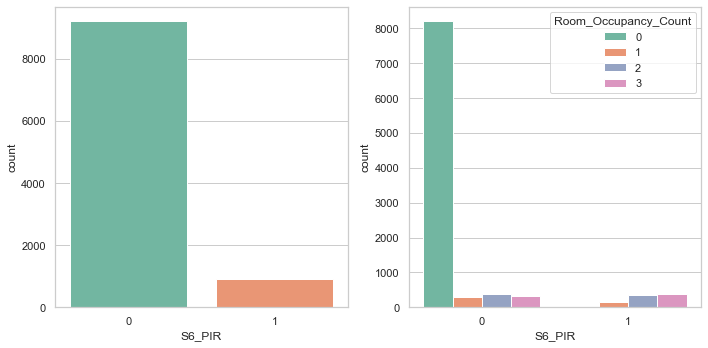

In [139]:
plt.rcParams["figure.figsize"] = [10.00, 5]
f, axes = plt.subplots(1, 2)
sns.countplot(x = 'S6_PIR', data = df_occupancy, ax=axes[0], palette=['#66c2a5', '#fc8d62'])
sns.countplot(x = 'S6_PIR', hue = 'Room_Occupancy_Count', data = df_occupancy, 
              ax=axes[1], palette=sns.color_palette('Set2'))
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

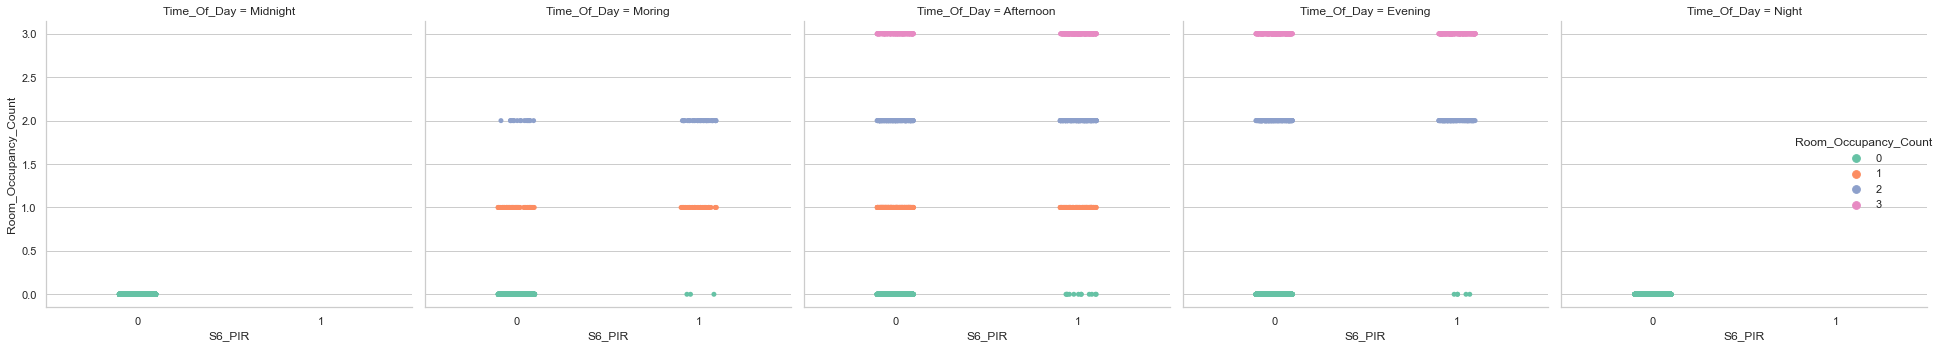

In [140]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='S6_PIR', y='Room_Occupancy_Count', 
                  col = 'Time_Of_Day',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));

viz.figure.savefig("S6_PIRVsTime.png")

plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

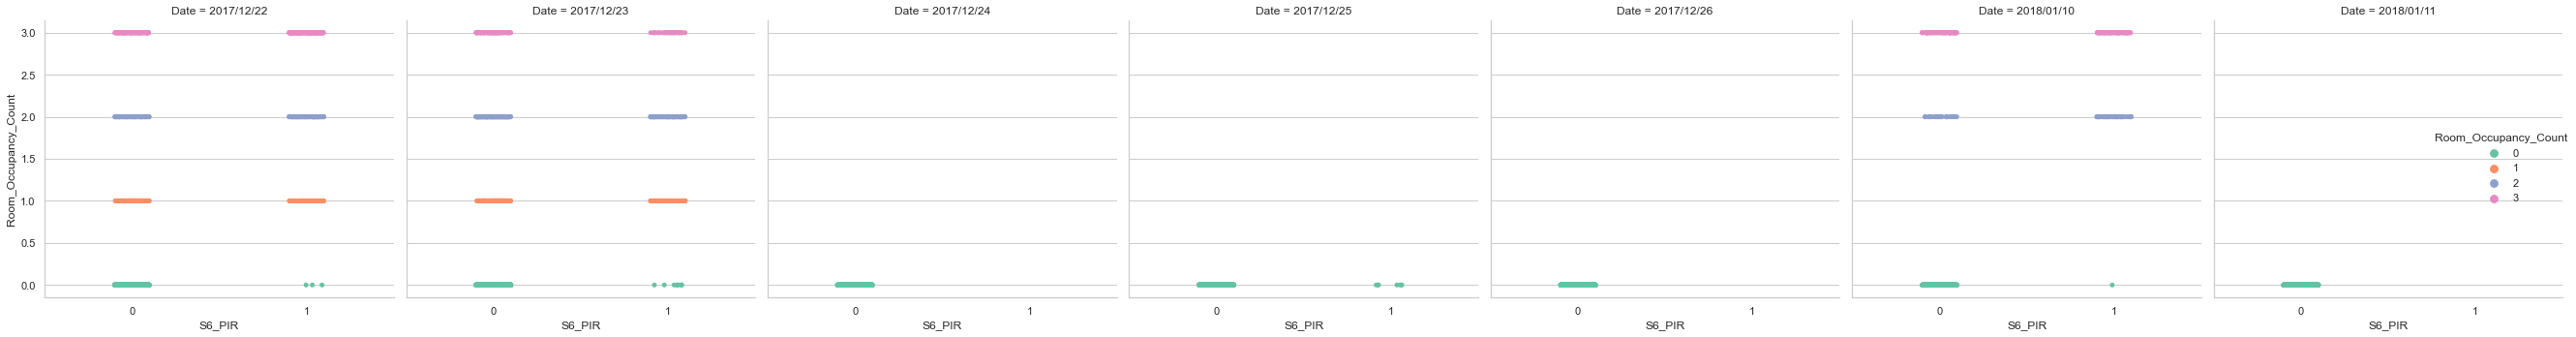

In [141]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='S6_PIR', y='Room_Occupancy_Count', #kind = "swarm",
                  col = 'Date',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));

viz.figure.savefig("S6_PIRVsDate.png")

plt.tight_layout()
plt.show()

## Visualization
**S7_PIR** Vs **Room_Occupancy_Count**

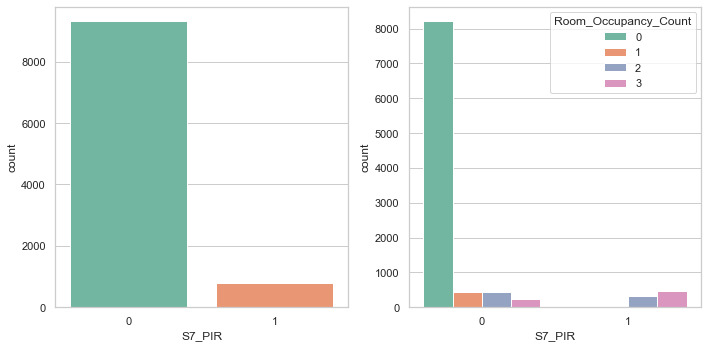

In [142]:
plt.rcParams["figure.figsize"] = [10.00, 5]
f, axes = plt.subplots(1, 2)
sns.countplot(x = 'S7_PIR', data = df_occupancy, ax=axes[0], palette=['#66c2a5', '#fc8d62'])
sns.countplot(x = 'S7_PIR', hue = 'Room_Occupancy_Count', data = df_occupancy, 
              ax=axes[1], palette=sns.color_palette('Set2'))
plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

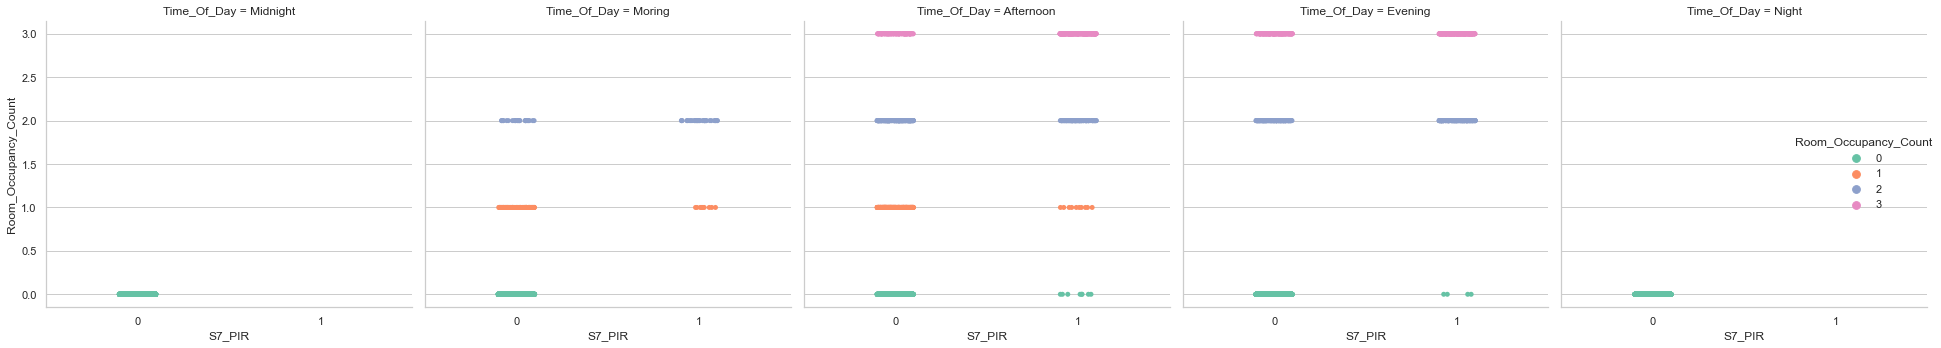

In [143]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='S7_PIR', y='Room_Occupancy_Count', 
                  col = 'Time_Of_Day',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));

viz.figure.savefig("S7_PIRVsTime.png")

plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

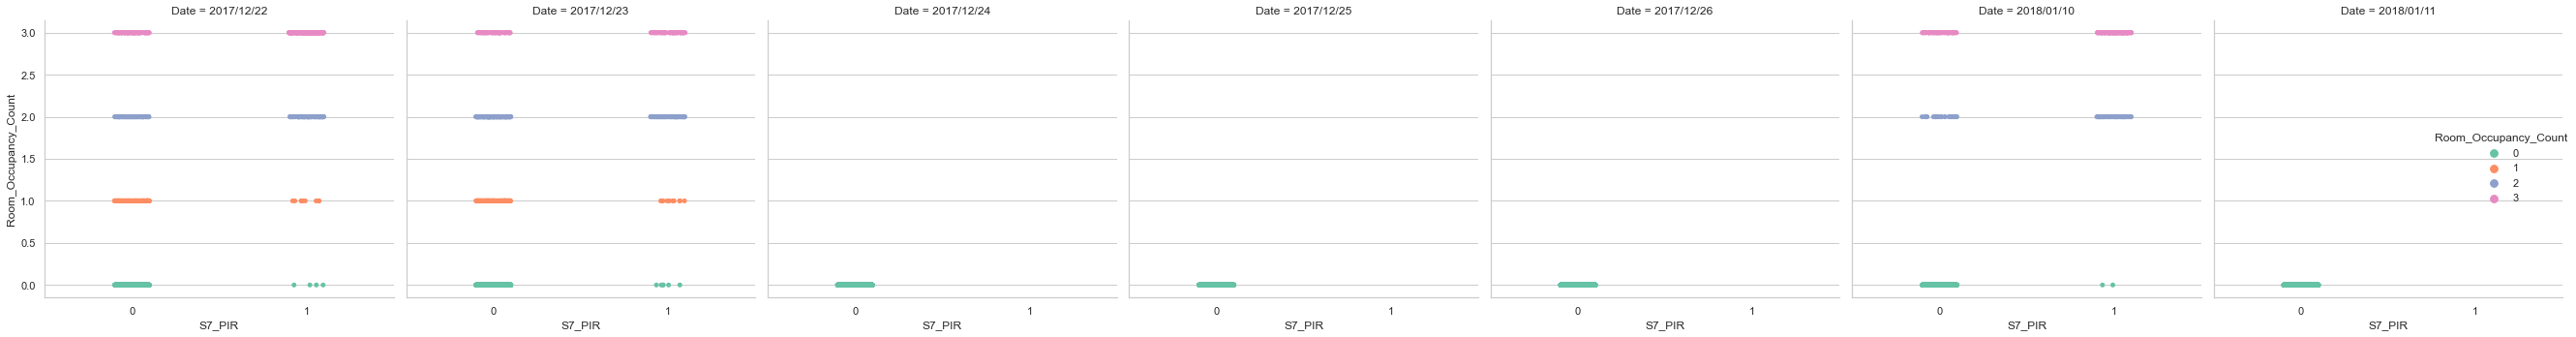

In [144]:
plt.figure(figsize=(10,5))
viz = sns.catplot(data = df_occupancy, x='S7_PIR', y='Room_Occupancy_Count', #kind = "swarm",
                  col = 'Date',
                  hue = 'Room_Occupancy_Count', palette=sns.color_palette('Set2'));

viz.figure.savefig("S7_PIRVsDate.png")

plt.tight_layout()
plt.show()

# 
## Best categorical Features (Chi-Square Test):

- **chi2:** is a statistical test that is used to determine whether there is a significant difference between the observed frequencies of a categorical variable and the expected frequencies. It is used to select the best categorical features for Room_Occupancy_Count.

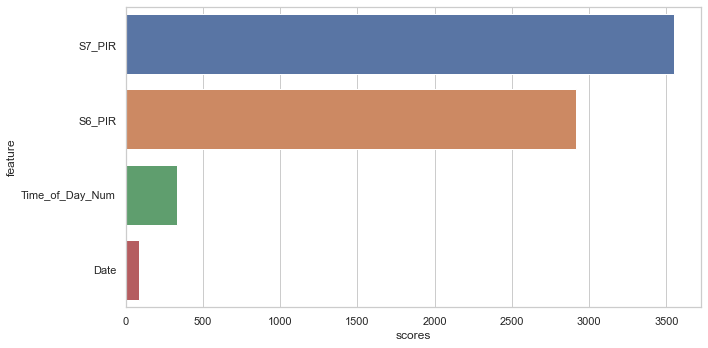

,feature,p-value,scores
0,S7_PIR,0.000000e+00,3548.368211
1,S6_PIR,0.000000e+00,2914.570104
2,Time_of_Day_Num,3.758998e-71,329.671331
3,Date,2.677279e-19,89.594301


In [145]:
df_cat = df_occupancy[['Room_Occupancy_Count' ,'Date', 'Time_of_Day_Num','S6_PIR', 'S7_PIR']]
df_cat['Date'] = pd.to_datetime(df_cat["Date"]).dt.strftime("%Y%m%d")

class_col = 'Room_Occupancy_Count' 
cat_cols = df_cat.columns[df_cat.columns != class_col]

X_train, X_test, y_train, y_test = train_test_split(df_cat[cat_cols], 
                                                    df_cat[class_col], 
                                                    stratify =  df_cat[class_col], random_state=1) 

fs = SelectKBest(score_func = chi2, k='all') 
fs.fit(X_train, y_train)                     

fs_cat = pd.DataFrame() 
fs_cat['feature'] = cat_cols 
fs_cat['p-value'] = fs.pvalues_ 
fs_cat['scores'] = fs.scores_ 

fs_catSorted = fs_cat.sort_values(by=['scores'], ascending=False)
fs_catSorted.reset_index(drop=True, inplace=True)

sns.barplot(data = fs_catSorted, y = 'feature', x = 'scores')

plt.tight_layout()
plt.show()

fs_catSorted[fs_catSorted['p-value'] < 0.05]

# 
# Modeling and Evaluation
 Multiple supervised learning models including **linear discriminant analysis** (LDA), **quadratic discriminant analysis** (QDA), **Linear SVM**, **RBF SVM**, **random forest** (RF) could be explored, in two phases:  
 
 1- **Homogeneous phase**: using one homogeneous sensor at a time  
 
 2- **Heterogeneous phase**: using multiple homogeneous sensors including one in each step  

 
## Data Normalization (addressing Sensitivity to Scale)  

 1- Models can be affected by the magnitude of input features. Features with large scales can have a more significant impact on the model learning process, leading to less performance.  
 
 2- **Normalization Procedure**: Normalization involves transforming the features so that they have zero mean and a standard deviation of 1.  
 
 3- **Training Set Features**: Only the training set features are used to calculate normalization. The normalization obtained from the training set then will be applied to both the training and testing sets consistently

 
## Cross Validation Evaluation
Model performance could be evaluated using metrics **Accuracy**, **F1 score**, and **confusion matrix**  

A combination of custom **TimeSeriesSplit** and **StratifiedKFold** cross-validation will be used.  

- Since the data is of time-series nature, data was not shuffled prior to cross validation (avoiding data points similar to test data getting into the training data)

- while maintaining  stratified sampling for a balanced distribution sampling of each class(addressing class-imbalance)

# 
# Homogeneous Phase

# 
# SVM (Linear) - Homogeneous - TimeSeriesSplit

In [146]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'],
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'],
    ['S6_PIR', 'S7_PIR'],
    ['S5_CO2'],
    ['S5_CO2_Slope'],
    ['S5_CO2', 'S5_CO2_Slope']
]

metrics_list = []
n_splits = 10

for features_to_include in homogeneous_sensors:
    current_features = [f for f in all_predictors if f in features_to_include]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    svm_model = SVC(kernel='linear')

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []
    
    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the Linear SVM model
            svm_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = svm_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)
            
#             cm = confusion_matrix(y_inner_test, y_pred)
#             print('Confusion Matrix:')
#             print(cm)
#             print('-' * 30)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy,3),
        'F1': round(mean_cv_f1Score,3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['SVM(Linear) - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒═══════════════════════════════╕
│ SVM(Linear) - TimeSeriesSplit │
╘═══════════════════════════════╛
╒════╤════════════════════╤═══════╤═══════╕
│    │ Feature            │ A     │ F1    │
╞════╪════════════════════╪═══════╪═══════╡
│ 0  │ ['Temp{1,2,3,4}']  │ 0.82  │ 0.621 │
├────┼────────────────────┼───────┼───────┤
│ 1  │ ['Light{1,2,3,4}'] │ 0.986 │ 0.968 │
├────┼────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}'] │ 0.777 │ 0.509 │
├────┼────────────────────┼───────┼───────┤
│ 3  │ ['PIR{6,7}']       │ 0.758 │ 0.442 │
├────┼────────────────────┼───────┼───────┤
│ 4  │ ['CO2']            │ 0.692 │ 0.338 │
├────┼────────────────────┼───────┼───────┤
│ 5  │ ['Slope']          │ 0.759 │ 0.422 │
├────┼────────────────────┼───────┼───────┤
│ 6  │ ['CO2', 'Slope']   │ 0.839 │ 0.622 │
╘════╧════════════════════╧═══════╧═══════╛


# 
# SVM (RBF) - Homogeneous - TimeSeriesSplit

In [147]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'],
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'],
    ['S6_PIR', 'S7_PIR'],
    ['S5_CO2'],
    ['S5_CO2_Slope'],
    ['S5_CO2', 'S5_CO2_Slope']
]

metrics_list = []
n_splits = 10

for features_to_include in homogeneous_sensors:
    current_features = [f for f in all_predictors if f in features_to_include]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    svm_model = SVC(kernel='rbf')

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []
    
    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the Linear SVM model
            svm_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = svm_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)
            
#             cm = confusion_matrix(y_inner_test, y_pred)
#             print('Confusion Matrix:')
#             print(cm)
#             print('-' * 30)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy,3),
        'F1': round(mean_cv_f1Score,3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['SVM(RBF) - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒════════════════════════════╕
│ SVM(RBF) - TimeSeriesSplit │
╘════════════════════════════╛
╒════╤════════════════════╤═══════╤═══════╕
│    │ Feature            │ A     │ F1    │
╞════╪════════════════════╪═══════╪═══════╡
│ 0  │ ['Temp{1,2,3,4}']  │ 0.833 │ 0.703 │
├────┼────────────────────┼───────┼───────┤
│ 1  │ ['Light{1,2,3,4}'] │ 0.986 │ 0.969 │
├────┼────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}'] │ 0.796 │ 0.57  │
├────┼────────────────────┼───────┼───────┤
│ 3  │ ['PIR{6,7}']       │ 0.749 │ 0.424 │
├────┼────────────────────┼───────┼───────┤
│ 4  │ ['CO2']            │ 0.647 │ 0.342 │
├────┼────────────────────┼───────┼───────┤
│ 5  │ ['Slope']          │ 0.755 │ 0.461 │
├────┼────────────────────┼───────┼───────┤
│ 6  │ ['CO2', 'Slope']   │ 0.85  │ 0.68  │
╘════╧════════════════════╧═══════╧═══════╛


# 
# RandomForest (RF) - Homogeneous - TimeSeriesSplit 

In [148]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'],
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'],
    ['S6_PIR', 'S7_PIR'],
    ['S5_CO2'],
    ['S5_CO2_Slope'],
    ['S5_CO2', 'S5_CO2_Slope']
]

metrics_list = []
n_splits = 10

for features_to_include in homogeneous_sensors:
    current_features = [f for f in all_predictors if f in features_to_include]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    # Use RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []

    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the Random Forest model
            rf_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = rf_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy, 3),
        'F1': round(mean_cv_f1Score, 3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['Random Forest - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒═════════════════════════════════╕
│ Random Forest - TimeSeriesSplit │
╘═════════════════════════════════╛
╒════╤════════════════════╤═══════╤═══════╕
│    │ Feature            │ A     │ F1    │
╞════╪════════════════════╪═══════╪═══════╡
│ 0  │ ['Temp{1,2,3,4}']  │ 0.809 │ 0.714 │
├────┼────────────────────┼───────┼───────┤
│ 1  │ ['Light{1,2,3,4}'] │ 0.967 │ 0.939 │
├────┼────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}'] │ 0.8   │ 0.603 │
├────┼────────────────────┼───────┼───────┤
│ 3  │ ['PIR{6,7}']       │ 0.748 │ 0.423 │
├────┼────────────────────┼───────┼───────┤
│ 4  │ ['CO2']            │ 0.602 │ 0.347 │
├────┼────────────────────┼───────┼───────┤
│ 5  │ ['Slope']          │ 0.724 │ 0.473 │
├────┼────────────────────┼───────┼───────┤
│ 6  │ ['CO2', 'Slope']   │ 0.809 │ 0.637 │
╘════╧════════════════════╧═══════╧═══════╛


# 
# Heterogeneous Phase

# 
# SVM (Linear) - Heterogeneous - TimeSeriesSplit

In [149]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    #THE COMPLETE DATASET
    [],
    #THE COMPLETE DATASET-devoiding Light Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    #THE COMPLETE DATASET-devoiding Light+PIR Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR'],
    #THE COMPLETE DATASET-devoiding Light+PIR+Sound Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
]

metrics_list = []
n_splits = 10

for features_to_exclude in homogeneous_sensors:
    current_features = [f for f in all_predictors if f not in features_to_exclude]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    svm_model = SVC(kernel='linear')

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []
    
    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the Linear SVM model
            svm_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = svm_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)
            
#             cm = confusion_matrix(y_inner_test, y_pred)
#             print('Confusion Matrix:')
#             print(cm)
#             print('-' * 30)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy,3),
        'F1': round(mean_cv_f1Score,3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['SVM(Linear) - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒═══════════════════════════════╕
│ SVM(Linear) - TimeSeriesSplit │
╘═══════════════════════════════╛
╒════╤═══════════════════════════════════════════════════════════════════════════════════╤═══════╤═══════╕
│    │ Feature                                                                           │ A     │ F1    │
╞════╪═══════════════════════════════════════════════════════════════════════════════════╪═══════╪═══════╡
│ 0  │ ['Light{1,2,3,4}', 'Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}'] │ 0.976 │ 0.95  │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 1  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}']                   │ 0.906 │ 0.821 │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope']                               │ 0.901 │ 0.812 │
├────┼────────────────────────────────────

# 
# SVM (RBF) - Heterogeneous - TimeSeriesSplit

In [150]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    #THE COMPLETE DATASET
    [],
    #THE COMPLETE DATASET-devoiding Light Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    #THE COMPLETE DATASET-devoiding Light+PIR Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR'],
    #THE COMPLETE DATASET-devoiding Light+PIR+Sound Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
]

metrics_list = []
n_splits = 10

for features_to_exclude in homogeneous_sensors:
    current_features = [f for f in all_predictors if f not in features_to_exclude]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    svm_model = SVC(kernel='rbf')

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []
    
    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the RBF SVM model
            svm_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = svm_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)
            
#             cm = confusion_matrix(y_inner_test, y_pred)
#             print('Confusion Matrix:')
#             print(cm)
#             print('-' * 30)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy,3),
        'F1': round(mean_cv_f1Score,3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['SVM(RBF) - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒════════════════════════════╕
│ SVM(RBF) - TimeSeriesSplit │
╘════════════════════════════╛
╒════╤═══════════════════════════════════════════════════════════════════════════════════╤═══════╤═══════╕
│    │ Feature                                                                           │ A     │ F1    │
╞════╪═══════════════════════════════════════════════════════════════════════════════════╪═══════╪═══════╡
│ 0  │ ['Light{1,2,3,4}', 'Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}'] │ 0.975 │ 0.954 │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 1  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}']                   │ 0.894 │ 0.82  │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope']                               │ 0.897 │ 0.83  │
├────┼─────────────────────────────────────────────

# 
# RandomForest (RF) - Heterogeneous - TimeSeriesSplit 

In [151]:
all_predictors = df_occupancy.columns.difference(['Room_Occupancy_Count', 'Date', 'Time', 'Time_Of_Day', 'Time_of_Day_Num']).tolist()

homogeneous_sensors = [
    #THE COMPLETE DATASET
    [],
    #THE COMPLETE DATASET-devoiding Light Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'],
    #THE COMPLETE DATASET-devoiding Light+PIR Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR'],
    #THE COMPLETE DATASET-devoiding Light+PIR+Sound Sensors
    ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S6_PIR', 'S7_PIR', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
]

metrics_list = []
n_splits = 10

for features_to_exclude in homogeneous_sensors:
    current_features = [f for f in all_predictors if f not in features_to_exclude]
    X = df_occupancy[current_features]
    y = df_occupancy['Room_Occupancy_Count']

    # Use RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_accuracies = []
    cv_f1_scores = []

    scaler = StandardScaler()

    # Loop for custom cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # StratifiedKFold within each TimeSeriesSplit fold
        stcv = StratifiedKFold(n_splits=n_splits)

        for inner_train_index, inner_test_index in stcv.split(X_train, y_train):
            X_inner_train, X_inner_test = X_train.iloc[inner_train_index], X_train.iloc[inner_test_index]
            y_inner_train, y_inner_test = y_train.iloc[inner_train_index], y_train.iloc[inner_test_index]

            # Normalize features using StandardScaler
            X_inner_train_scaled = scaler.fit_transform(X_inner_train)
            X_inner_test_scaled = scaler.transform(X_inner_test)

            # Train and evaluate the Random Forest model
            rf_model.fit(X_inner_train_scaled, y_inner_train)
            y_pred = rf_model.predict(X_inner_test_scaled)

            accuracy = accuracy_score(y_inner_test, y_pred)
            cv_accuracies.append(accuracy)

            # Use weighted (F1) for imbalanced classes
            f1 = f1_score(y_inner_test, y_pred, average='macro')
            cv_f1_scores.append(f1)

    # Calculate and store mean cross-validation accuracy, F1 for the current feature combination
    mean_cv_accuracy = sum(cv_accuracies) / len(cv_accuracies)
    mean_cv_f1Score = sum(cv_f1_scores) / len(cv_f1_scores)

    metrics_dict = {
        'Feature': current_features,
        'A': round(mean_cv_accuracy, 3),
        'F1': round(mean_cv_f1Score, 3)
    }

    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

for index, row in metrics_df.iterrows():

    current_features = row['Feature']
    
    updated_features = []

    for feature in current_features:
        if 'Temp' in feature:
            if 'Temp{1,2,3,4}' not in updated_features:
                updated_features.append(f'Temp{{1,2,3,4}}')
        elif 'Slope' in feature:
            updated_features.append('Slope')
        elif 'CO2' in feature:
            updated_features.append('CO2')
        elif 'Sound' in feature:
            if 'Sound{1,2,3,4}' not in updated_features:
                updated_features.append(f'Sound{{1,2,3,4}}')
        elif 'PIR' in feature:
            if 'PIR{6,7}' not in updated_features:
                updated_features.append(f'PIR{{6,7}}')
        elif 'Light' in feature:
            if 'Light{1,2,3,4}' not in updated_features:
                updated_features.append(f'Light{{1,2,3,4}}')
        else:
            updated_features.append('')

    metrics_df.at[index, 'Feature'] = updated_features

table = [['Random Forest - TimeSeriesSplit']]
print(tabulate(table,  tablefmt='fancy_grid'))
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', colalign=("left","left","left","left")))

╒═════════════════════════════════╕
│ Random Forest - TimeSeriesSplit │
╘═════════════════════════════════╛
╒════╤═══════════════════════════════════════════════════════════════════════════════════╤═══════╤═══════╕
│    │ Feature                                                                           │ A     │ F1    │
╞════╪═══════════════════════════════════════════════════════════════════════════════════╪═══════╪═══════╡
│ 0  │ ['Light{1,2,3,4}', 'Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}'] │ 0.964 │ 0.932 │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 1  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope', 'PIR{6,7}']                   │ 0.892 │ 0.813 │
├────┼───────────────────────────────────────────────────────────────────────────────────┼───────┼───────┤
│ 2  │ ['Sound{1,2,3,4}', 'Temp{1,2,3,4}', 'CO2', 'Slope']                               │ 0.887 │ 0.806 │
├────┼──────────────────────────────